# 1: Preparation of the Dataset:

The first step is to prepare the dataset for future use:

**Getting an extended Dataset:**
 1. Get new Data from https://www.bluebikes.com/system-data
 2. Download the zip files fore each month of 2015 - Boston
 3. concattenate them without the header line
 4. elaborate a meaningful header for the boston trip data
 5. Download the station-data from 2011-2016
 6. elaborate a meaningful header for the station data

We provided alle datasets needed for the data preparation in the ilias assignment upload as a zip file.


# Implementation




# Preparation

This section deals with the data preparation and cleaning of the data

### Libraries
First we need to install the libraries needed for the calculations.

In [76]:
#The most recent version of statsmodels is needed, so in case statsmodels is not up to date, run the next line
#%pip install --upgrade statsmodels

import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
import math
import time
import operator
from datetime import datetime, timedelta
import numpy as np
import requests
import urllib.parse
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import gmap
from bokeh.models import GMapOptions, ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import Blues8, Oranges8

#Machine Learning
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

### Meta settings
Next we will define some meta settings, like the default figsize for the plots and the datatypes & locations for the data.

In [77]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 12]
pd.options.mode.chained_assignment = None 
radius_palette = Blues8 + tuple(reversed(Oranges8))

In [78]:
# This cell is needed for using the jupyter notebook in Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [79]:
# File locations and datatypes

API_KEY = ""
GOOGLE_MAPS_DATA_FILE = "./datasets/google_api_data.json"

TRIP_DATA_PATH = "./datasets/boston_bluebike_2015_data.csv"
WEATHER_DATA_PATH = "./datasets/weather_hourly_boston.csv"
STATION_DATA_PATH = "./datasets/Hubway_Stations_2011_2016.csv"

TRIP_DTYPES = {
    "duration_in_seconds": "int64",
    "start_time": "datetime64",
    "end_time" : "datetime64",
    "start_station_id":"int64",
    "start_station_name": "str",
    "start_station_lat": "float64",
    "start_station_lng": "float64",
    "end_station_id": "int",
    "end_station_name": "str",
    "end_station_lat": "float64",
    "end_station_lng": "float64",
    "bike_id": "int64",
    "user_type": "str",
    "birth_year": "int64",
    "gender": "int64"
}

WEATHER_DTYPES = {
    "max_temp": "float64",
    "min_temp": "float64",
    "precip": "int64"
}

STATION_DTYPES = {
    "station_name": "str",
    "station_id_string": "str",
    "lat": "float64",
    "lng": "float64",
    "municipality": "str",
    "dock_number": "int64"
}

scaler = StandardScaler()

In [80]:
# Initializing Google Maps Dependencies
output_notebook()
bokeh_width, bokeh_height = 800,600


Loading BokehJS ...

### Loading the data
Here we load the data into our notebook. 
We have 3 types of data:
1. Trip_data: the individual trips, each trip represented as a record
2. weather_data: the data of the weather conditions for the year
3. station_data: the individual data for the different bike stations

As the data has missing values indicated by "\\N", we will replace them with the numpy representation of NaN.

There is one end_station with a NaN value (the bike didn't seem to have been returned...) so we will fill this data with a "-1" for "no station"

After this, we parse the data as its corresponding types, missing values will be represented as -1.


In [81]:
trip_data = pd.read_csv(TRIP_DATA_PATH)
weather_data = pd.read_csv(WEATHER_DATA_PATH)
station_data = pd.read_csv(STATION_DATA_PATH)

#replace all the missing values with NaN
trip_data = trip_data.replace('\\N', np.nan)
weather_data = weather_data.replace('\\N', np.nan)
station_data = station_data.replace('\\N', np.nan)

#Set the id of the NaN Station to -1
trip_data["end_station_id"] = trip_data["end_station_id"].fillna(value=-1)

trip_data = trip_data.fillna(-1).astype(TRIP_DTYPES)
station_data = station_data.astype(STATION_DTYPES)
weather_data["date_time"] = pd.to_datetime(weather_data["date_time"])

/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Modifying the trip and weather data

Next we will extend the data with useful information. We will check the possible usertypes and will enumerate them in a seperate column.

In [82]:
# As we can see, there are only 2 types of user_types! Therefore we can binarize this into its own column.
trip_data["user_type"].unique()

array(['Subscriber', 'Customer'], dtype=object)

In [83]:
#Add ID for Usertype to simplify clustering later on | 1 = Subscriber, 0 = Customer
trip_data["user_type_id"] = trip_data.apply(lambda row: 
1 if row.user_type == "Subscriber" 
else 0, axis=1)

The weatherdata does have a bigger scope than we need, so we will filter it by the year 2015 and sort it by date.

In [84]:
#Filtering the weather data for 2015 and sorting it chronologically
weather_data = weather_data[weather_data["date_time"]<pd.to_datetime("2016-01-01 00:00:00")]
weather_data = weather_data.sort_values(by="date_time")

For the weather data we needed to make some assumptions on how to interpret the data.

**Assumption 1**: For the duplicates we assume, the weather changes during the hour. But we do not have any indication, in which part of the hour the weather changes, so we will take the first record of each duplicate.

**Assumption 2**: The time, the trip starts is the important one for the weather, as this is when the customer decides to use the bike.

**Assumption 3**: As there are data-fields missing in weather_data we assume, that the weather did not change over that time, therefore we will fill that hour with the previous weather conditions. 

In [85]:
#Cleanup of the weather data and splitting it into hours
weather_data = weather_data.drop_duplicates(subset="date_time", keep="first")

#here we generate all hours of 2015, so that we have each hour represented in the weather data
hours_2015 = pd.DataFrame(pd.date_range(pd.to_datetime("2015-01-01 00:00:00"),pd.to_datetime("2015-12-31 23:00:00"),freq='H'),columns= ["date_time"])
full_hours = pd.merge(how="outer", left=weather_data, right=hours_2015, on="date_time").sort_values(by="date_time").reset_index(drop=True)

full_hours = full_hours.set_index("date_time")

#Fill the missing values with ffill and bfill
full_hours = full_hours.fillna(method='ffill')
full_hours = full_hours.fillna(method='bfill').astype(WEATHER_DTYPES)

Next, we add the weather data to the trip data, so we will have the temparature and the precip for each trip.

In [86]:
#Merging the weather data into the trip data.
trip_data = pd.merge_asof(trip_data.sort_values("start_time"), full_hours.sort_index(), left_on="start_time", right_index=True, direction="backward")

### Modifying the station data

Next we will check the station data. As a lot of the station data is in the trip_data as well (like lat and lng info), we will take the trip data into account as well.

First we want to assert, that we are dealing with the same set of stations in start and end stations

In [87]:
#Checking the unique count of station_name and station_id
start_station_names = trip_data["start_station_name"].unique()
start_station_ids = trip_data["start_station_id"].unique()
end_station_names = trip_data["end_station_name"].unique()
end_station_ids = trip_data["end_station_id"].unique()


#Checking the station_data used actively in 2015 
print(f"Start Station ID's: {len(start_station_ids)}")
print(f"Start Station Names: {len(start_station_names)}")
print()
print(f"End Station ID's: {len(end_station_ids)}")
print(f"End Station Names: {len(end_station_names)}")
print()
print(f"Union to check, if the IDs are the same: {len(np.union1d(start_station_ids,end_station_ids))}")
print("We can see, that the stations fit with each other. The 1 difference is the one bike trip with 'no station' as its \ndestination")

Start Station ID's: 156
Start Station Names: 156

End Station ID's: 157
End Station Names: 157

Union to check, if the IDs are the same: 157
We can see, that the stations fit with each other. The 1 difference is the one bike trip with 'no station' as its 
destination


Now we want to assert, that the lat and lng data is in fact the same:

In [88]:
# Asserting, that start_station_id and end_station_id have in fact the same stations(except for the one broken bike).
# This means, we can sufficiently use the larger set (end_stations) as a basis for our station data frame.
start_stations = trip_data.drop_duplicates(subset="start_station_id", keep="first")[["start_station_id","start_station_name", "start_station_lat", "start_station_lng"]].sort_values(by="start_station_id").reset_index(drop=True)
end_stations = trip_data.drop_duplicates(subset="end_station_id", keep="first")[["end_station_id","end_station_name", "end_station_lat", "end_station_lng"]].sort_values(by="end_station_id").reset_index(drop=True)

#As we can see, the stations provide the same data about latitude and longitude
start_stations.merge(end_stations, left_on='start_station_id', right_on="end_station_id", how='outer', suffixes=['', '_'], indicator=True)

stations = end_stations.rename(columns={"end_station_id":"station_id","end_station_name":"station_name", "end_station_lat": "lat", "end_station_lng": "lng"})

next, we will join the information that we just extracted from the trip data to the station data of the bluebikes website.

In [89]:
#As we can see, the stations fit almost perfectly with the name of the stations data from bluebikes!
#We are merging based on ther station_name, as the station_id differs in trip_data & station_data!
station_data = station_data.drop(['lat', 'lng'], axis=1).merge(stations, right_on="station_name", left_on="station_name", how='right')

#We are only interested in the stations, where trips have been made to or from, thats why we choose the "right"-join

#Because the fit is not perfect, there are still rows with NaN values
rows_with_NaN = station_data[station_data.isnull().any(axis=1)]

rows_with_NaN

station_name station_id_string municipality  \
0                                         -1               NaN          NaN   
1                      18 Dorrance Warehouse               NaN          NaN   
80   Brookline Village - Pearl Street @ MBTA               NaN          NaN   
102   TD Garden - Causeway at Portal Park #1               NaN          NaN   
122  Upham's Corner - Ramsey St at Dudley St               NaN          NaN   
124                   Summer St at Cutter St               NaN          NaN   

     dock_number  station_id        lat        lng  
0            NaN          -1  -1.000000  -1.000000  
1            NaN           1  42.387151 -71.075978  
80           NaN          86  42.332799 -71.116205  
102          NaN         109  42.365942 -71.060515  
122          NaN         130  42.317225 -71.065421  
124          NaN         132  42.394002 -71.120406

we have some data that is still missing from the bluebikes dataset. We will take google maps Search information to fill the municipality into that and will put Magic values for station_id_string and -1 for the dock_number. 

Finally we will fill the "no station" with -1.

In [90]:
#We will fill the missing municipality by reverse searching the station name with the google maps API (previously used for lat/lng pairs)
#This was done with another python script an the Google Maps 'findplacefromtext' API. The Script can be found below.
data = json.load(open(GOOGLE_MAPS_DATA_FILE))

#For each record with a NaN value, we will lookup the stationID in the JSON provided by the reverse search
for index, row in rows_with_NaN.iterrows():
    #we will skip the No Station Entry (-1)
    if row.station_id == -1:
        continue
    station_id = row.station_id
    json_station_data = data[str(station_id)]["candidates"][0]
    original_station = station_data[station_data.station_id == station_id]
    
    #We will split the data to find the municipality. 
    #Sometimes no direct address is provided, so we need to check the length of the split.
    #If the length is 4, an address is provided, if its 3, then no address is provided
    formatted_address = json_station_data["formatted_address"].split(",")
    municipality = formatted_address[0].strip() if len(formatted_address) == 3 else formatted_address[1].strip()    
    
    #we will fill out the original dataframe with the JSON data
    station_data.at[station_data.station_id == station_id, "municipality"] = municipality
    

#The missing dock_number will be filled with -1, to imply that no information is provided here
station_data["dock_number"] = station_data["dock_number"].fillna(-1)
#The station_id in string form (from the station bluebikes csv file) will be filled with the magic value X000000 to match the convention
station_data["station_id_string"] = station_data["station_id_string"].fillna("X00000")
#The rest (which happens to be only the "No Station" record) will be filled with -1
station_data.at[station_data.station_id == -1, "lat"] = -1
station_data.at[station_data.station_id == -1, "lng"] = -1
station_data.at[station_data.station_id == -1, "municipality"] = -1

Now we add interesting data about the counts of each station and information for the maps visualisation later.

In [91]:
#Counting the amount of trips for each station
end_station_count = pd.DataFrame(trip_data.end_station_id.value_counts())
start_station_count = pd.DataFrame(trip_data.start_station_id.value_counts())

#Renaming the columns to make it easier to merge them
end_station_count = end_station_count.rename(columns={"end_station_id": "end_station_count"})
start_station_count = start_station_count.rename(columns={"start_station_id": "start_station_count"})

#Merging the Count into the station_data
station_data = station_data.merge(end_station_count, right_index=True, left_on="station_id")
station_data = station_data.merge(start_station_count, right_index=True, left_on="station_id", how='left').fillna(0)
print(station_data.info())
station_data.start_station_count = station_data.start_station_count.astype(np.int64)

#Adding total_count (sum of start and end station count) | Adding map_radius for better map visualisation
station_data["total_count"] = station_data["start_station_count"] + station_data["end_station_count"]
station_data["map_count_radius"] = station_data["total_count"] / 1100
station_data["map_count_radius"] = station_data.apply(lambda row: 7 if row["map_count_radius"] < 7 else row["map_count_radius"], axis=1)

#Adding the colors, in which the stations will be represented on the map. The smallest 6 also include the "no station", which is why we will takte the smallest 6 stations.
lowest_total_count = list(station_data.nsmallest(6, "total_count").station_id)
highest_total_count = list(station_data.nlargest(5, "total_count").station_id)
def set_map_color(row):
    if row["station_id"] in lowest_total_count:
        return "blue"
    elif row["station_id"] in highest_total_count:
        return "green"
    else:
        return "red"

station_data["map_count_color"] = station_data.apply(lambda row: set_map_color(row), axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 156
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_name         157 non-null    object 
 1   station_id_string    157 non-null    object 
 2   municipality         157 non-null    object 
 3   dock_number          157 non-null    float64
 4   station_id           157 non-null    int64  
 5   lat                  157 non-null    float64
 6   lng                  157 non-null    float64
 7   end_station_count    157 non-null    int64  
 8   start_station_count  157 non-null    float64
dtypes: float64(4), int64(2), object(3)
memory usage: 12.3+ KB
None


In [92]:
#Adding start_end_ratio (ratio between start and end using situation of each station ) | Adding map_radius_ratios for better map visualisation

station_data["map_ratio_radius"] = station_data["start_station_count"] / station_data["end_station_count"]
station_data.sort_values(by=['map_ratio_radius'])

station_data["ratio_bins"] = pd.qcut(station_data["map_ratio_radius"], len(radius_palette), range(len(radius_palette)))
radius_colors = pd.DataFrame({"numbers": np.linspace(station_data["map_ratio_radius"].min(),station_data["map_ratio_radius"].max(),len(radius_palette)),
              "colors": radius_palette})

#Adding the colors, in which different kinds of stations will be represented on the map.(Red: more end than start; Blue: more start than end)
station_data["map_ratio_color"] = station_data.apply(lambda row: radius_colors["colors"][row["ratio_bins"]], axis=1)

## Preparing the prediction data
In this section we will prepare the data for the 3 models, which will be used for the hour demand prediction. This will be the source dataset used for the features and labels, the scaling and preparation for the individual model will be done within the implementation of that model in the later session.

### Polynomial dataset
Poly_data will be our dataset for the polynomial prediction. for this we will take into account:
- Month of the year
- day of the month
- day of the week
- hour of the day
- precip
- min_temparature

We need to take the day of the month as well to difference the different "mondays" that a month has, so it doesn't add all of them up.

This dataset does not need to be filled with all hours of the year 2015 because it is independend of previous steps and has no seasonality, where shifts in an 24 hour order make a difference.

In [93]:
#JD
Poly_data = trip_data.groupby([
    trip_data["start_time"].dt.month, 
    trip_data["start_time"].dt.day, 
    trip_data["start_time"].dt.weekday, 
    trip_data["start_time"].dt.hour,
    trip_data["precip"],
    np.floor(trip_data["min_temp"])]).size().rename("hourly_demand")#.sample(frac=1)

Poly_data.index.rename(["month", "day", "weekday", "hour", "precip", "min_temp"], inplace=True)
Poly_data = Poly_data.reset_index()


### ARIMA dataset
ARIMA_hours will be the dataset for our ARIMA prediction. This will take only the timeseries and the hourly demand into account.

In [94]:
#First we will take a copy of the trip_data and round the hour
trip_data_copy = trip_data.copy()
trip_data_copy["start_time"] = trip_data_copy["start_time"].dt.floor("H")

ARIMA_data = pd.DataFrame(trip_data_copy.groupby(trip_data_copy["start_time"]).size().rename("hourly_demand"))
# Adding the 2015 hours, so we have an hour representation for each hour.
ARIMA_hours = pd.merge(how="outer", left=ARIMA_data, right=hours_2015, left_index=True, right_on="date_time").set_index('date_time').sort_index().fillna(0)

### LSTM dataset
LSTM_data will be the dataset for our LSTM prediction. It will take min- and max_temparature and precip, as well as the steps and the hourly demand of the last step into account.

In [95]:
#JD

LSTM_data = trip_data.groupby([trip_data["start_time"].dt.floor("H")]).size().rename("hourly_demand")
LSTM_data = pd.merge(LSTM_data, full_hours, 'outer', left_index=True, right_index=True).fillna(0)


### Test labels
Here we will define the last 500 hours for the test_labeling.

In [96]:
print(LSTM_data[-500:].head())
print(ARIMA_hours[-500:].head())
print(Poly_data[-500:].head())

                     hourly_demand  max_temp  min_temp  precip
2015-12-11 04:00:00            0.0       7.2       7.2       0
2015-12-11 05:00:00           11.0       7.8       7.2       0
2015-12-11 06:00:00           50.0       7.2       6.7       0
2015-12-11 07:00:00          188.0       7.2       6.7       0
2015-12-11 08:00:00          296.0       7.2       6.7       0
                     hourly_demand
date_time                         
2015-12-11 04:00:00            0.0
2015-12-11 05:00:00           11.0
2015-12-11 06:00:00           50.0
2015-12-11 07:00:00          188.0
2015-12-11 08:00:00          296.0
      month  day  weekday  hour  precip  min_temp  hourly_demand
7721     12   10        3     4       0       6.0              1
7722     12   10        3     5       0       7.0             13
7723     12   10        3     6       0       7.0             64
7724     12   10        3     7       0       6.0            169
7725     12   10        3     8       0       6.0   

# 2: Plotting the data
In this section, we will plot the data we have to nicely visualize patterns and clusters.

### Google Maps
First we will plot the location data on a the boston map.


In [97]:
#Lat / Lng is chosen to display boston, station_data holds information about the different stations
gmap_options = GMapOptions(lat= 42.3580089, lng=-71.1004676, map_type='roadmap', zoom=12)
map_source = ColumnDataSource(station_data)


The first plot shows the total count of the different stations: 
- The size represents the count
- blue represents the 5 lowest count stations
- green represents the 5 highest count stations


The second plot shows the ratio of bikes being delivered to a station and those who have been taken from a station. If the ratio is 1 (white), just as much bikes have been delivered as have been taken, so it is balanced. The more red and blue it gets, the more the bike demand is unbalanced (blue= more bikes than needed, red = less bikes than needed)

In [98]:
#Function for plotting the boston count data in a google maps iframe
hover_count = HoverTool(tooltips = [('Station', '@station_name'), ('Count', '@total_count')])

p_count = gmap(API_KEY, gmap_options, title='Boston Bike Station Distribution', 
               width=bokeh_width, height=bokeh_height, 
               tools=[hover_count, 'reset', 'wheel_zoom', 'pan']
              )
p_count.circle('lng', 'lat', size='map_count_radius', alpha=0.4, 
                  color='map_count_color', source=map_source)

#Function for plotting the ratio data in a google maps iframe
hover = HoverTool(tooltips = [('Station', '@station_name'), ('Ratio', '@map_ratio_radius')])

p_ratio = gmap(API_KEY, map_options = gmap_options, title='Boston Bike Station Distribution(Ratio of Start and End)',
               width=bokeh_width, height=bokeh_height, 
               tools=[hover, 'reset', 'wheel_zoom', 'pan']
              )
p_ratio.circle('lng', 'lat', size=10, alpha=0.4, 
               color='map_ratio_color', source=map_source)

show(p_count)
show(p_ratio)

### Plotting the trip data
In this section, we will plot different types of aggregated trip data.

In [99]:
#Create Bar Chart out of a plot
def autolabel(rects): 
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.- 0.2, 1.03*height, '%s' % int(height))

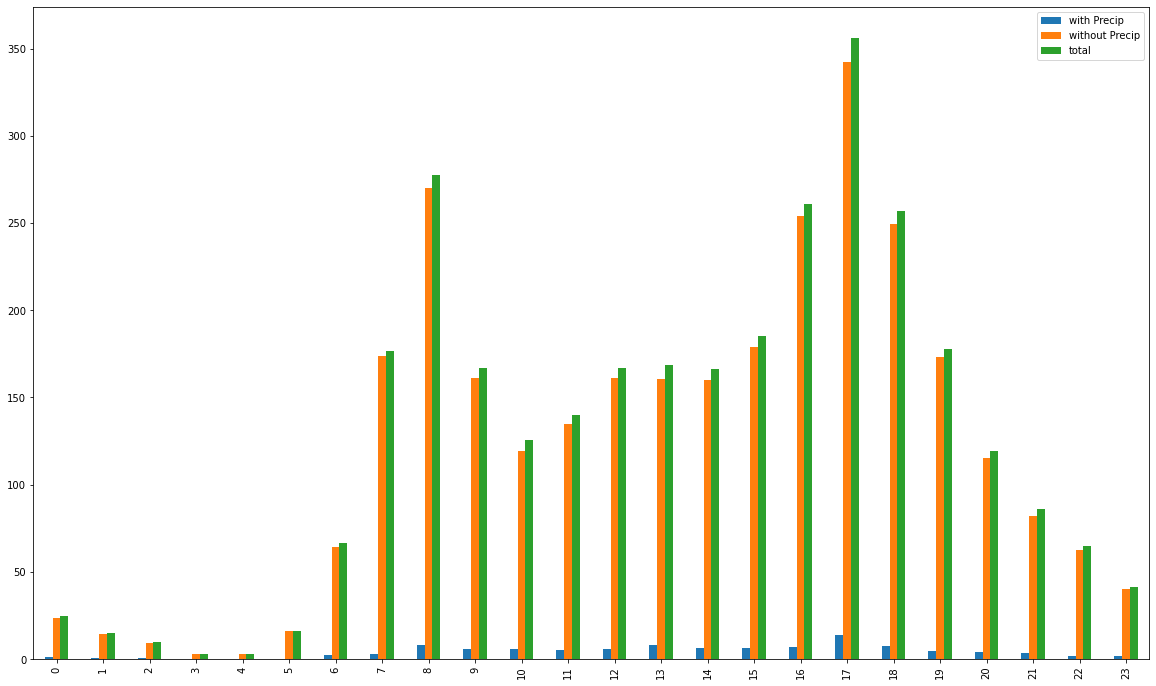

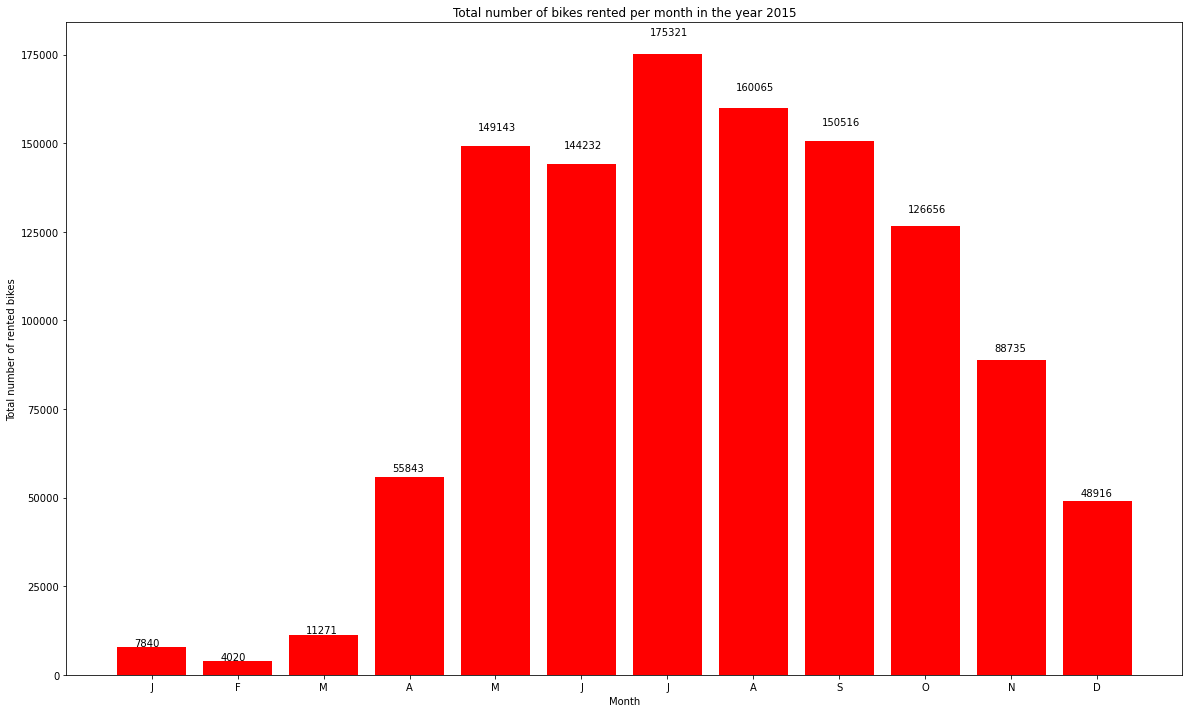

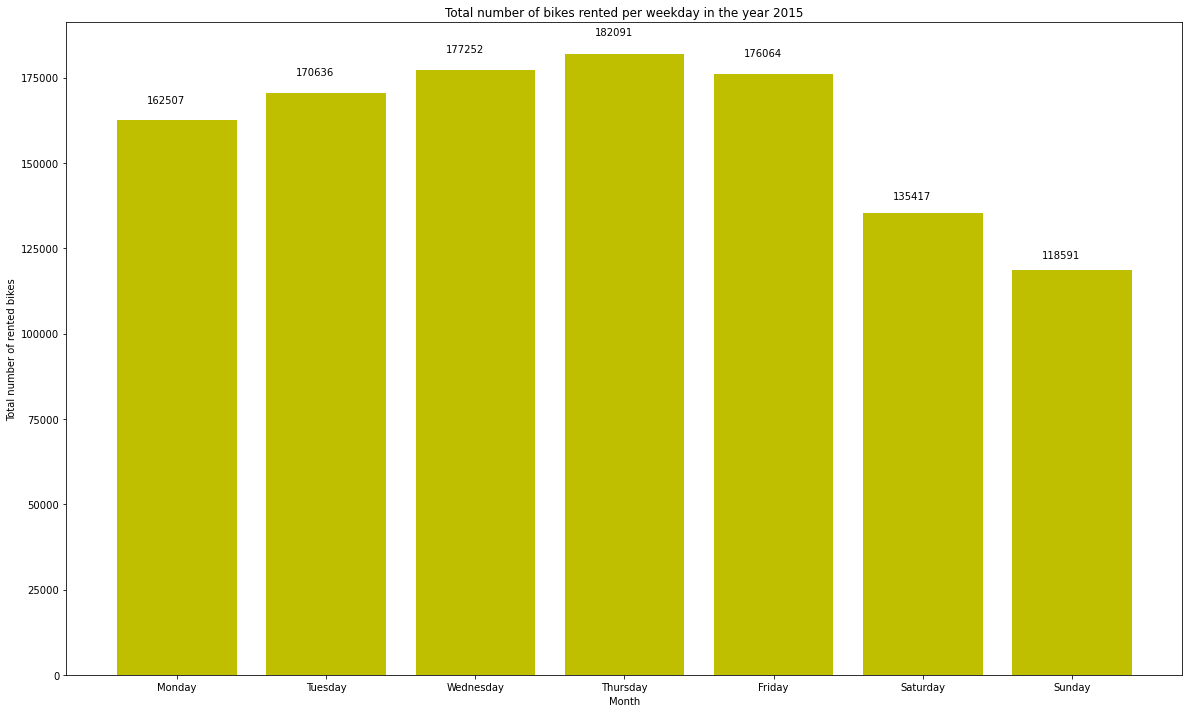

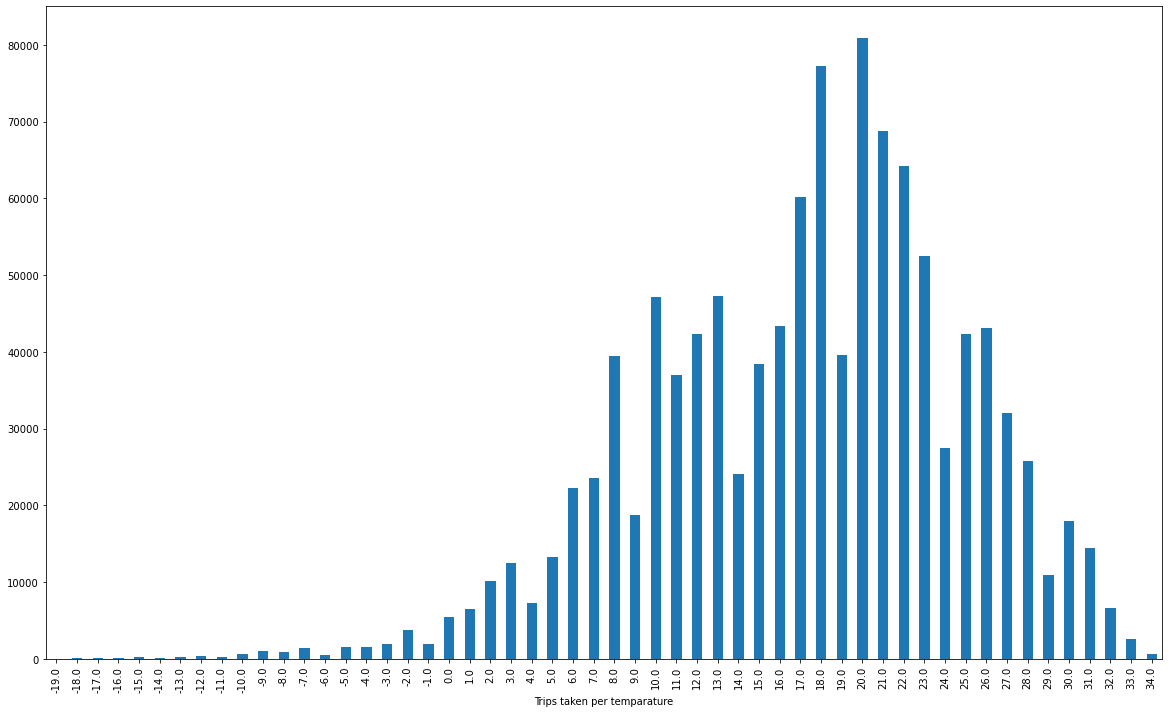

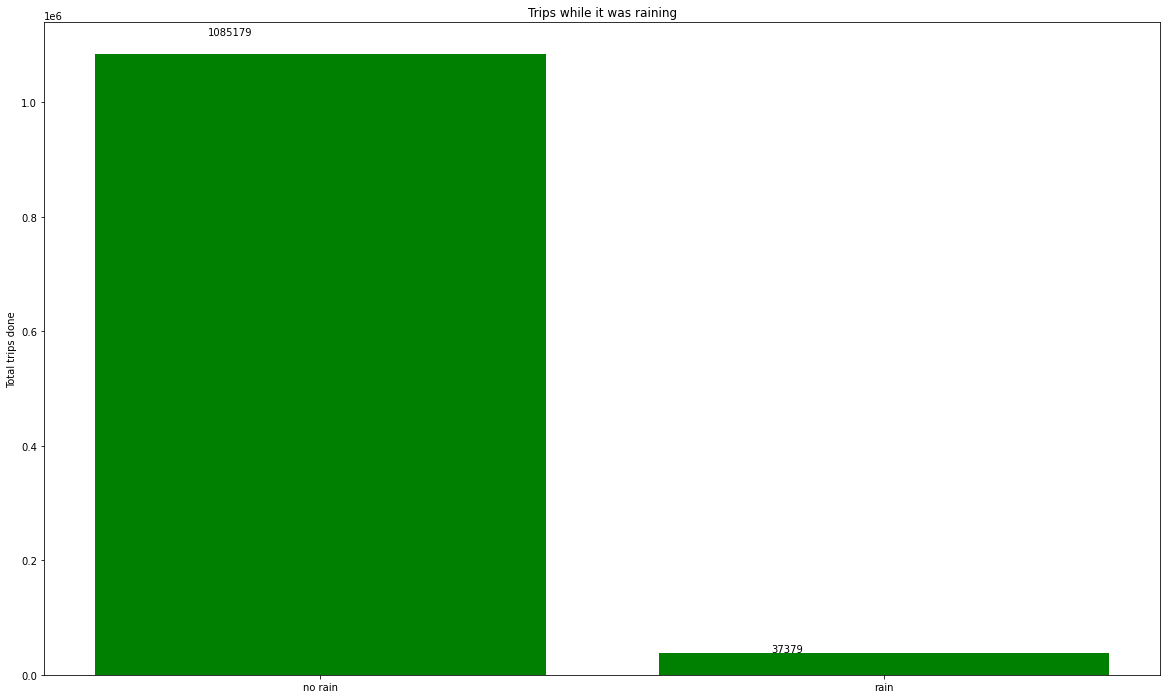

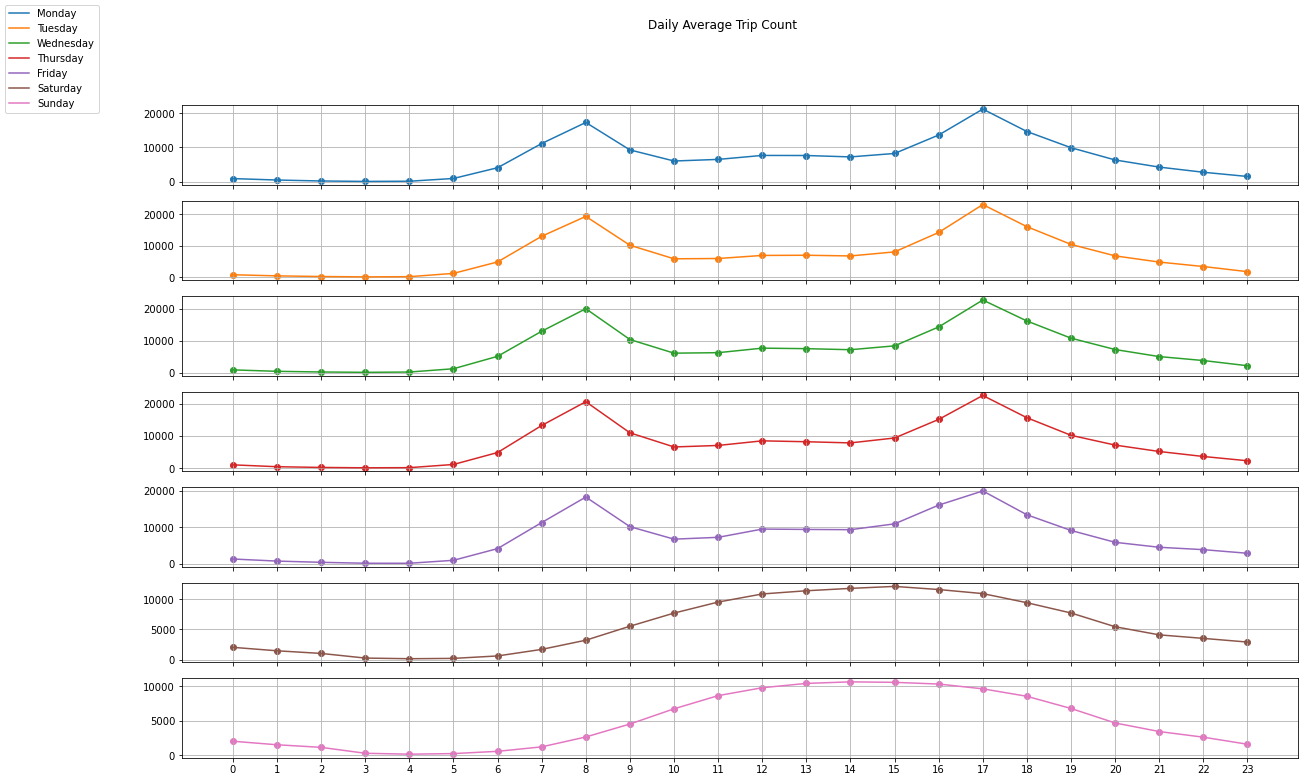

In [100]:
# How many bikes were rented during the day in average over the year per hour 

hours = trip_data[['start_time', 'precip']]
hours['start_time'] = pd.to_timedelta(hours['start_time'].dt.hour, unit='H')

result2 = hours.groupby(["start_time", "precip"]).size().reset_index(name='counts')
result2['counts'] = result2['counts'].div(365)



concatedGraphs = pd.concat(
    [result2[result2['precip'] == 1].reset_index()["counts"].rename("with Precip"), 
     result2[result2['precip'] == 0].reset_index()["counts"].rename("without Precip"),
    result2.groupby(["start_time"]).sum().reset_index()["counts"].rename("total")],
    axis=1)

#concatedGraphs.plot().get_figure().savefig('./figs/dataDescription/hourly.jpeg')
concatedGraphs.plot.bar()

#How many bikes were rented per month in total in 2015!

months = trip_data['start_time'].dt.month
grouped_months = months.groupby(months).size().reset_index(name='counts')

fig = plt.figure(figsize=(20,12))
bins = ['J','F','M','A','M','J','J','A','S','O','N','D']

plt.title('Total number of bikes rented per month in the year 2015')
plt.xlabel('Month')
plt.ylabel('Total number of rented bikes')
autolabel(plt.bar(grouped_months['start_time'], grouped_months['counts'], color='r', tick_label=bins))

#plt.savefig('./figs/dataDescription/monthly.jpeg')
plt.show()

#How many bikes were rented per month in total in 2015!

weeks = trip_data['start_time'].dt.day_name()
result = weeks.groupby(weeks).size().reset_index(name='counts')
result = result.reindex([1,5,6,4,0,2,3])
fig = plt.figure(figsize=(20,12))

bins = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.title('Total number of bikes rented per weekday in the year 2015')
plt.xlabel('Month')
plt.ylabel('Total number of rented bikes')
autolabel(plt.bar(result['start_time'], result['counts'], color='y', tick_label=bins))

#plt.savefig('./figs/dataDescription/weekly.jpeg')
plt.show()


#At what Temparature have the most trips been taken
mean_temps = (trip_data['min_temp'] + trip_data['max_temp']) / 2
mean_temps = mean_temps.apply(np.floor).rename("Trips taken per temparature")

mean_temps_data = mean_temps.groupby(mean_temps).count().plot.bar()


#How many trips have been taken while it was raining

ifRaining = trip_data['precip']
groupedByRain = ifRaining.groupby(ifRaining).size().reset_index(name='counts')

fig = plt.figure(figsize=(20,12))
bins = ['no rain','rain']

plt.title('Trips while it was raining')
plt.xlabel('')
plt.ylabel('Total trips done')

autolabel(plt.bar(bins, groupedByRain['counts'], color='g', tick_label=bins))

Weekdays = sorted(Poly_data.weekday.unique())
Weekdays_meta = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday" ]

Weekday_counts = [Poly_data[Poly_data["weekday"] == weekday].groupby(["hour"]).sum()["hourly_demand"] for weekday in Weekdays]

def draw_Weekdays(ys, labels):
    colors = plt.rcParams["axes.prop_cycle"]()
    fig, axes = plt.subplots(nrows=len(ys), sharex=True)
    fig.suptitle("Daily Average Trip Count")

    for ax, y, label in zip(axes.flat, ys, labels):
        x = range(0, 24)
        c = next(colors)["color"]
        ax.plot(x, y, label=label, color=c)
        ax.scatter(x, y, color=c)
        ax.set_xticks(x)
        ax.grid(True)

    fig.legend(loc="upper left")
    #plt.savefig('./figs/dataDescription/weekdays.jpeg')
    plt.show()

draw_Weekdays(Weekday_counts, Weekdays_meta)


In [101]:

print("Addition to the raining/snowing statistic")
print(f"In this year there were {full_hours['precip'].sum() / full_hours['precip'].count() * 100}% rainy days, but ")
print(f"of all the trips, only {groupedByRain.iloc[1].values[1] / (groupedByRain.iloc[1].values[1] +  groupedByRain.iloc[0].values[1])*100}% of trips have been taken during rain.")

Addition to the raining/snowing statistic
In this year there were 8.938356164383562% rainy days, but 
of all the trips, only 3.3298056759650723% of trips have been taken during rain.


### Plotting the prediction data

Here we can see the weather data and total demand over time

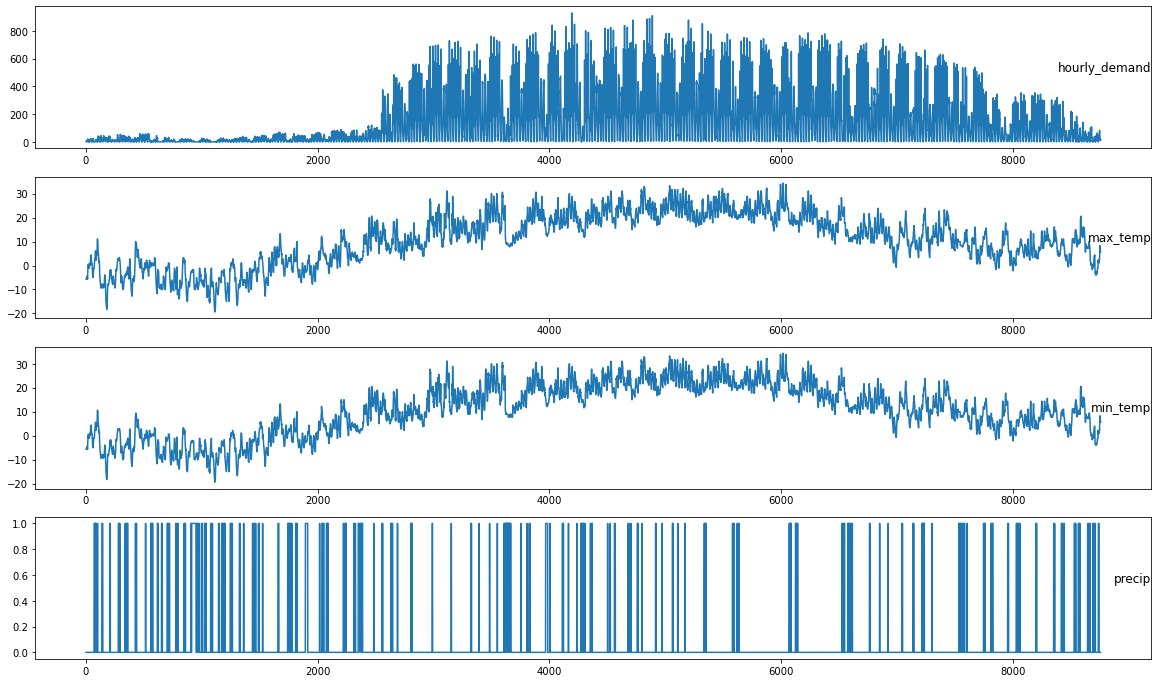

In [102]:
lstm_values = LSTM_data.values
# specify columns to plot
lstm_groups = [0, 1, 2, 3]
lstm_i = 1
# plot each column
plt.figure()
for group in lstm_groups:
	plt.subplot(len(lstm_groups), 1, lstm_i)
	plt.plot(lstm_values[:, group])
	plt.title(LSTM_data.columns[group], y=0.5, loc='right')
	lstm_i += 1

#plt.savefig('./figs/dataPrediction/weatherAndTotalDemand.jpeg')
plt.show()

Here we can see the different seasonal effects of the hourly demand. 

The spikes of the daily seasonality are the 9:00 and 17:00 marks.
The lower parts of the weekly seasonality are the weekends.


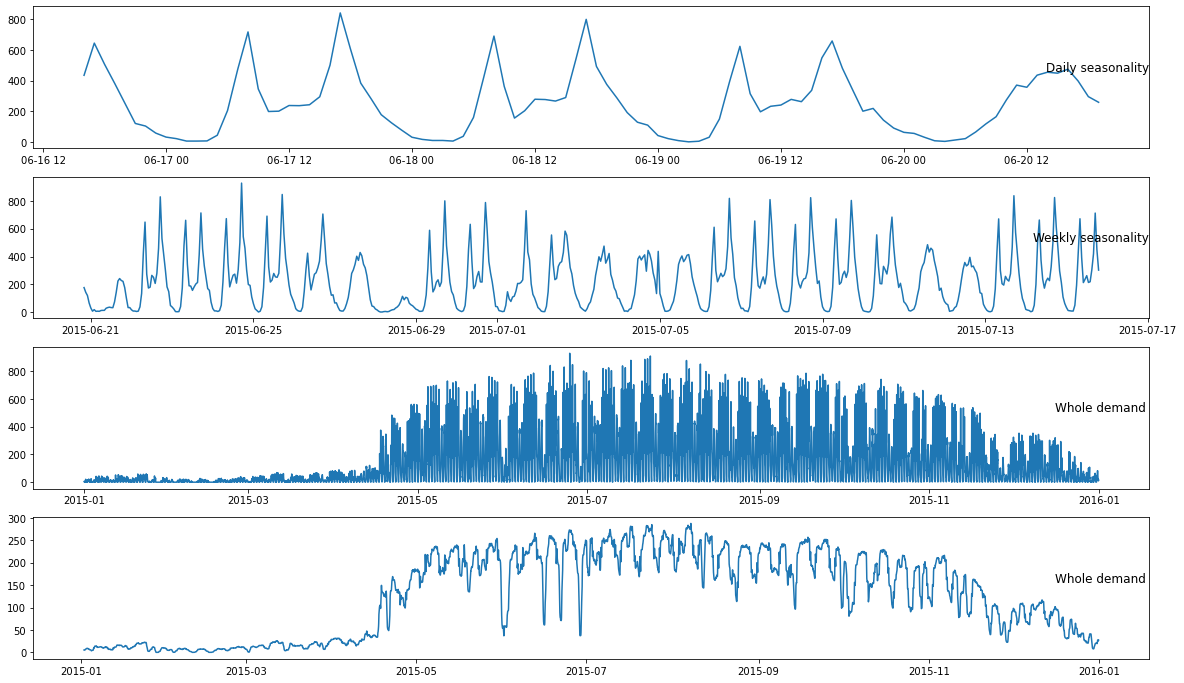

In [103]:
plt.figure()

plt.subplot(4, 1, 1)
plt.plot(ARIMA_hours[4000:4100])
plt.title("Daily seasonality", y=0.5, loc='right')

plt.subplot(4, 1, 2)
plt.plot(ARIMA_hours[4100:4700])
plt.title("Weekly seasonality", y=0.5, loc='right')

plt.subplot(4, 1, 3)
plt.plot(ARIMA_hours)
plt.title("Whole demand ", y=0.5, loc='right')

plt.subplot(4, 1, 4)
plt.plot(ARIMA_hours.rolling(window=24).mean())
plt.title("Whole demand ", y=0.5, loc='right')

#plt.savefig('./figs/dataPrediction/seasonalEffects.jpeg')
plt.show()

**Based on the Figures we saw, we can identify different interesting behaviours**

1. The hour and the time of the year make a huge difference, the peaks are during 9:00 and 17:00. An explanation for this could be the trip to and from work.
2. People ride more often in the summer months (starting from may) than in the winter months.
3. People ride bikes more during monday-friday (which could be also lead back to the fact, that people use the bike often to get to work.
4. The biggest Blocker for people taking trips seems to be precip
5. The sweetspot for trips taken based on temparature seems to be between 18-20 degrees Celsius.

Though the rides are highest during the summer months, the main causation could be ultimately the temparature (most likely is), as the temparature correlates with the summer months as well.

# 2b: KPIs

## Preparation

Before calculating the KPIs and plotting them we need to prepare some variables used throught out the section.  

Since the idea is to use these KPIs as a real time tracker for managers, we decided always use the current date and time and pretend to be in the year 2015. Based on this we were able to plot the last 24 hours of the "current" date and time.

In [104]:
#Create Bar Chart out of a plot
def autolabelFloat(rects): 
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.- 0.2, 1.03*height, '%s' % "{:.2f}".format(float(height)))

# set the "current" Date for further calculations
current_rain_status = 0.0
current_temperature = 20

currentDate = datetime.today().date()
currentTime = datetime.today().time()

fakeCurrentDate = datetime(year=2015, month=currentDate.month, day=currentDate.day, hour=currentTime.hour, minute=currentTime.minute) 

## KPI 1: Utilization

The first KPI displays the current utilization of the fleet on an hourly bases of the last 24 hours. Since the number of vehicles fluctuate over the year we approximate the currently used number of bikes by counting the bikes used in the last 7 days.

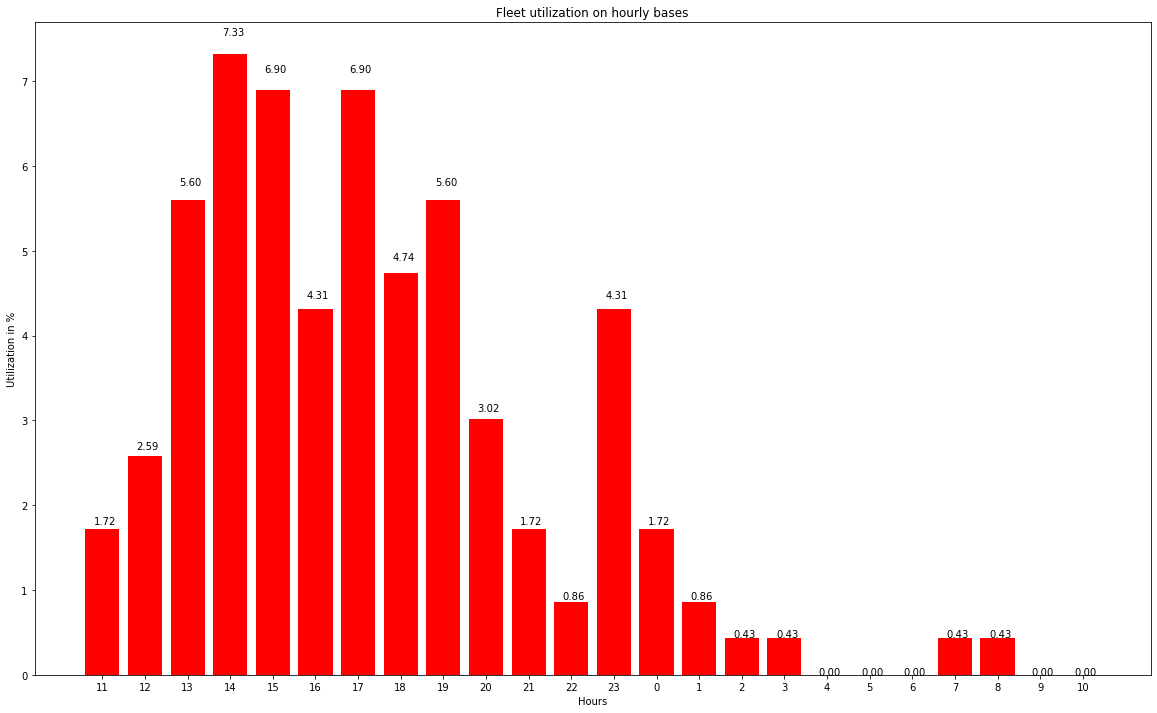

In [105]:
#fakeCurrentDate = datetime.date(2015,current_month,current_day)
#twoWeeksAgo = fakeCurrentDate - timedelta(days=14)

result_kpi1_a = pd.DataFrame(columns=['time', 'utilization'])
loopDate = fakeCurrentDate - timedelta(hours=23)

# Approximation of vehicles in the fleet
bike_count_starttime = loopDate - timedelta(days=7)
    
trip_data_bikes_after = trip_data["start_time"] >= bike_count_starttime
trip_data_bikes_before = trip_data["start_time"] <= loopDate
between_two_dates_bike = trip_data_bikes_after & trip_data_bikes_before
trip_data_bikes = trip_data.loc[between_two_dates_bike]

bike_count = trip_data_bikes["bike_id"].groupby(trip_data_bikes["bike_id"]).size().size


#calculate the utilization of the last 24 hours
for x in range(24):
    start_calculation = loopDate - timedelta(hours=1)
    
    trip_data_after = trip_data["start_time"] >= start_calculation
    trip_data_before = trip_data["start_time"] <= loopDate
    between_two_dates = trip_data_after & trip_data_before
    filtered_dates = trip_data.loc[between_two_dates]   
    filtered_dates_durations = filtered_dates["bike_id"].groupby(filtered_dates["bike_id"]).size().size

    mean = (filtered_dates_durations / bike_count) * 100       
    hour = loopDate.hour
    
    result_kpi1_a = result_kpi1_a.append({'time': hour, 'utilization': mean}, ignore_index=True)
    
    loopDate = loopDate + timedelta(hours=1)

# now plot the data starting with the 23 hours ago till the current hour on the very right
fig = plt.figure(figsize=(20,12))
bins = result_kpi1_a['time'].astype('int32').values

plt.title('Fleet utilization on hourly bases')
plt.xlabel('Hours')
plt.ylabel('Utilization in %')
autolabelFloat(plt.bar(result_kpi1_a['time'].astype('int32').astype('str').values, result_kpi1_a['utilization'], color='r', tick_label=bins))

#plt.savefig('./figs/kpis/utilization.jpeg')
plt.show()


Utilizations are quite low at the moment since its winter. But even if manually changing the month to July, gave only a maximum of 50%. This indicates a very promissing KPI needing to be improved, for a better revenue.

## KPI 2: Revenue

The KPI revenue shows the revenue made in the last 24 hours per hour in comparison to the average revenue made per hour. The input is the current precipitation, so you have a better comparison, since precipitation is presumably the biggest factor affecting revenue.

In [106]:
# Filter trips with(-out) precip for better comparison
precip = 0.0
revenue_daily = trip_data[['duration_in_seconds', 'start_time', 'end_time']].loc[(trip_data['precip'] == precip)]

# Calculate how often 30 min fits into trip duration
revenue_daily['count_payments'] = trip_data['duration_in_seconds'].div(1800)

# Round values up/down 
revenue_daily['count_payments'] = revenue_daily['count_payments'].astype(int)

# Calculate total payment
revenue_daily['total_payment'] = 2.95 + revenue_daily['count_payments'] * 2.5

# Group by hours based on endtime bc thats were payment is fulfilled
revenue_daily['time'] = pd.to_timedelta(revenue_daily['end_time'].dt.hour, unit='H')
result_revenue_daily = revenue_daily.groupby(['time']).size().reset_index(name='total_revenue_per_hour')

# Calculate daily average
result_revenue_daily['average_hourly_revenue'] = result_revenue_daily['total_revenue_per_hour'].div(365)

# Change time to hour only
result_revenue_daily['time'] = result_revenue_daily['time'].dt.components['hours']

In [107]:
# Get last 24h trips and calculate revenue per hour
result_kpi2 = pd.DataFrame(columns=['time', 'revenue'])
loopDate = fakeCurrentDate - timedelta(hours=23)

# Calculate the revenue of the last 24 hours per hour
for x in range(24):
    start_calculation = loopDate - timedelta(hours=1)
    
    trip_data_after = revenue_daily["start_time"] >= start_calculation
    trip_data_before = revenue_daily["start_time"] <= loopDate
    between_two_dates = trip_data_after & trip_data_before
    filtered_dates = revenue_daily.loc[between_two_dates]   
    filtered_dates_total_payment_sum = filtered_dates["total_payment"].sum()
       
    hour = loopDate.hour
    
    result_kpi2 = result_kpi2.append({'time': hour, 'revenue': filtered_dates_total_payment_sum}, ignore_index=True)
    
    loopDate = loopDate + timedelta(hours=1)

# Calculate KPI: Last24h/Average per hour full year (with rain/without rain)
result_kpi_revenue = pd.merge(result_kpi2, result_revenue_daily, on="time")
result_kpi_revenue['kpi_revenue'] = result_kpi_revenue['revenue'] / result_kpi_revenue['average_hourly_revenue'] * 100

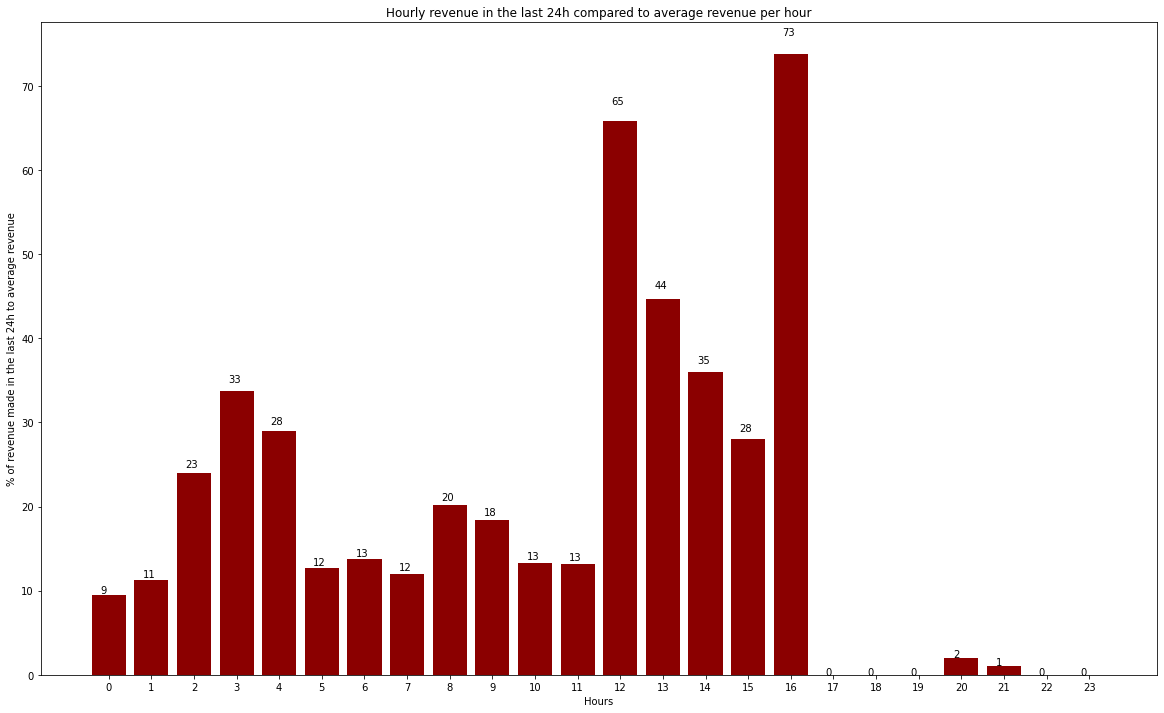

In [108]:
# Visualize KPI revenue
fig = plt.figure(figsize=(20,12))

count_values = result_kpi_revenue.count().time
bins = []
for i in range(count_values):
    bins.append(i)


# Change bins to time
autolabel(plt.bar(bins, result_kpi_revenue['kpi_revenue'], color=np.where(result_kpi_revenue['kpi_revenue']>100, 'darkgreen', 'darkred'), tick_label=bins))
plt.ylabel('% of revenue made in the last 24h to average revenue')
plt.xlabel('Hours')
plt.title('Hourly revenue in the last 24h compared to average revenue per hour')

#plt.savefig('./figs/kpis/revenue.jpeg')

plt.show()

The data shows that hourly revenue over the last 24 hours is quite low overall compared to the entire year. This makes sense, since trips drop significantly when temperatures are low. For a better conclusion, a comparison with similar temperature levels would be helpful so that you can determine other factors that could lead to low revenue.

## KPI 3: Coverage

### KPI 3.1 Coverage map

The coverage map shows the top five stations where either more trips are started than ended or more trips are ended than started. The assumption is that operational intervention is needed to ensure that the right amount of bicycles are available at the right stations at the right time.

In [109]:
station_coverage = station_data

#Get difference between start station and end station
station_coverage["difference_count"] = station_coverage["end_station_count"] - station_coverage["start_station_count"]

# Top 5 stations where more bikes are arriving than driving away
top_5_largest_difference = station_coverage.nlargest(5, "difference_count")

# Top 5 stations where more bikes are driven away than arriving 
top_5_smallest_difference = station_coverage.nsmallest(5, "difference_count")

# Change map circle colors according to smallest/biggest difference
top_5_largest_difference["map_count_color"] = 'red'
top_5_smallest_difference["map_count_color"] = 'blue'

# Change map radius
top_5_largest_difference["map_count_radius"] = top_5_largest_difference["difference_count"] / 100
top_5_smallest_difference["map_count_radius"] = top_5_smallest_difference["difference_count"] / (-75)

# Merge data
top_5_difference = top_5_largest_difference.append(top_5_smallest_difference)

# Show gmap with 5 biggest/lowest difference
map_source = ColumnDataSource(top_5_difference)
#Function for plotting the boston count data in a google maps iframe
hover_count = HoverTool(tooltips = [('Station', '@station_name'), ('Difference', '@difference_count')])

p_count = gmap(API_KEY, gmap_options, title='Boston Bike Station Distribution', 
               width=bokeh_width, height=bokeh_height, 
               tools=[hover_count, 'reset', 'wheel_zoom', 'pan']
              )
p_count.circle('lng', 'lat', size='map_count_radius', alpha=0.7, 
                  color='map_count_color', source=map_source)

show(p_count)

On the map, the top 5 stations where more bike trips end than start are shown in red. You can see that there is a massive surplus near the university. Therefore, if a large surplus is found, it might make sense to take the bikes and move them to another station where the demand is, such as near the blue circles, since more bikes leave there than arrive.

### KPI 3.2 Coverage per station

The coverage per station KPI takes a single station as input and visualizes the difference between starting and ending trips. This is in addition to KPI 3.1 to check a station and see if it is necessary to intervene at the current time.

In [110]:
# Provide station id as input
input_station_id = 115

# Starting trips - counts_x
coverage_per_station_starting_trips = trip_data[['start_station_id', 'start_time', 'end_time']].loc[(trip_data['start_station_id'] == input_station_id)]
coverage_per_station_starting_trips['time'] = pd.to_timedelta(coverage_per_station_starting_trips['start_time'].dt.hour, unit='H') 
result_coverage_per_station_starting_trips = coverage_per_station_starting_trips.groupby(["time"]).size().reset_index(name='counts')

# Ending trips - counts_y
coverage_per_station_ending_trips =  trip_data[['end_station_id', 'start_time', 'end_time']].loc[(trip_data['end_station_id'] == input_station_id)]
coverage_per_station_ending_trips['time'] = pd.to_timedelta(coverage_per_station_ending_trips['end_time'].dt.hour, unit='H') 
result_coverage_per_station_ending_trips = coverage_per_station_ending_trips.groupby(["time"]).size().reset_index(name='counts')

# Merge counts together
result_coverage_per_station = pd.merge(result_coverage_per_station_starting_trips, result_coverage_per_station_ending_trips, on="time")

# Calculate difference between starting and ending trips
result_coverage_per_station['difference_per_station'] = result_coverage_per_station['counts_x'] - result_coverage_per_station['counts_y']

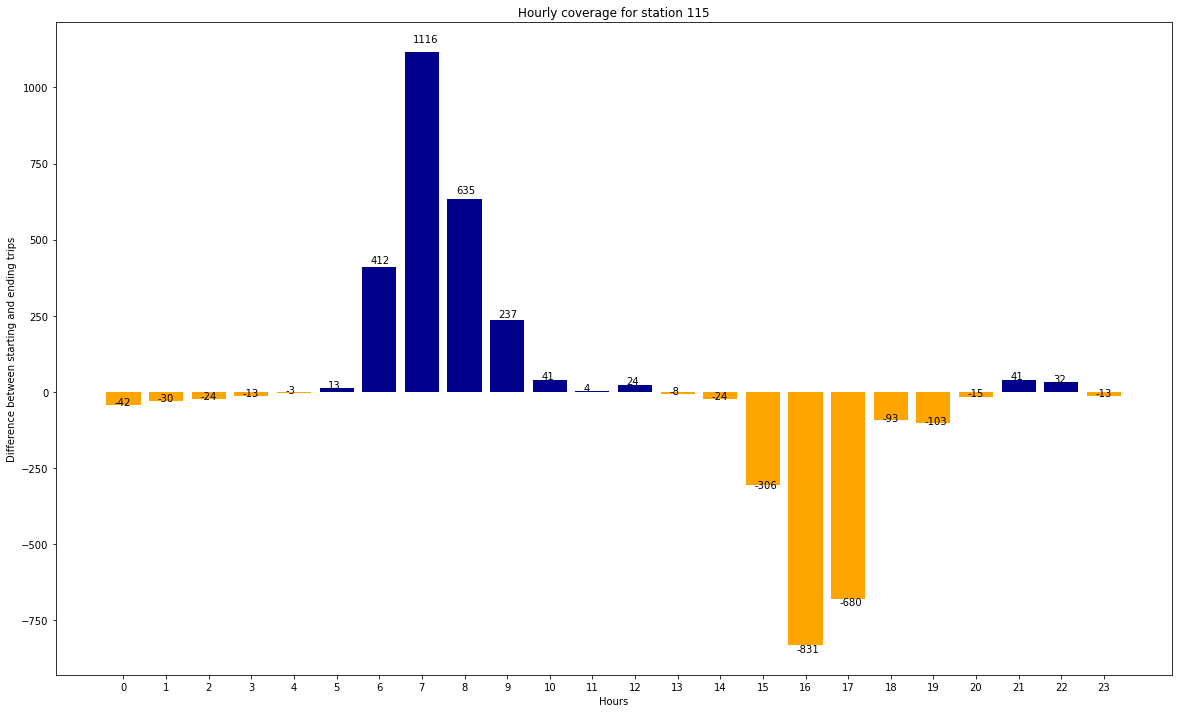

In [111]:
fig = plt.figure(figsize=(20,12))

count_values = result_coverage_per_station.count().time
bins = []
for i in range(count_values):
    bins.append(i)


# Change bins to time
autolabel(plt.bar(bins, result_coverage_per_station['difference_per_station'], color=np.where(result_coverage_per_station['difference_per_station']>0, 'darkblue', 'orange'), tick_label=bins))
plt.ylabel('Difference between starting and ending trips')
plt.xlabel('Hours')
plt.title('Hourly coverage for station ' + str(input_station_id))

#plt.savefig('./figs/kpis/coverageGraph1.jpeg')

plt.show()

The data shows that for example station 80 - MIT Stata Center at Vassar St / Main St - has more trips ending than starting in the morning (orange) and more trips starting than ending in the evening (blue). Therefore, the station is probably close to a big working place and people are driving from home to work and finish their trips at the according station.

For station 115 - Porter Square Station - it is the other way around. Therefore, you can conclude, that it is important to intervene accordingly and provide enough bikes to satisfy demand at the right times.

# 3a: Customer types Clustering

## Data Prep and Scaling

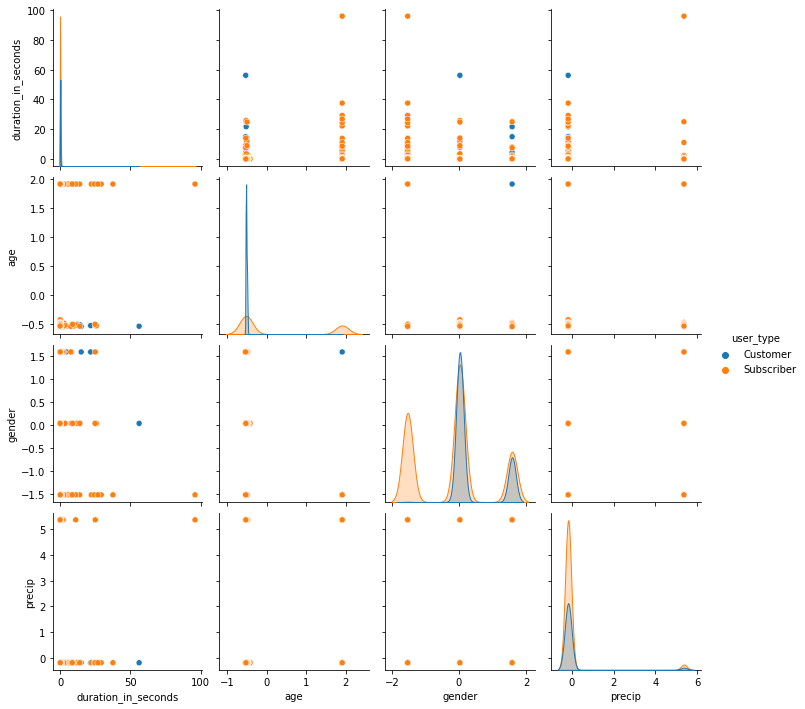

In [112]:
# Since the values of birth_year are quite closer to each other, which might create difficulties in Clustering later, we calculate "age" based on "birth_year"
trip_data[["age"]] = 2015-trip_data[["birth_year"]] 
Clustering_dataset = trip_data[["duration_in_seconds", "age","gender","user_type","precip"]]

# Sampling(in order to don't take so much time) and check if Customer types can be simply seperated into Subscriber and Customer given by original dataset
gbr = Clustering_dataset.groupby("user_type") 
gbr.groups

#Proportional Sampling
typicalFracDict = {          
    'Subscriber': 0.02, 
    'Customer': 0.02
}
 
def typicalSampling(group, typicalFracDict):
    name = group.name
    frac = typicalFracDict[name]
    return group.sample(frac=frac)
 
Clustering_sample = Clustering_dataset.groupby(
    'user_type', group_keys=False
).apply(typicalSampling, typicalFracDict)

# Data Partition and Visualisation
X_sample = Clustering_sample.drop("user_type", axis=1)
y_sample = Clustering_sample[["user_type"]]
scaler.fit(X_sample)
X_scaled_sample = scaler.transform(X_sample)
X_scaled_sample_df = pd.DataFrame(X_scaled_sample, columns=X_sample.columns, index=X_sample.index)
trip_scaled = X_scaled_sample_df
trip_scaled["user_type"] = Clustering_sample["user_type"]
pairplot = sns.pairplot(data=trip_scaled, hue="user_type")

#pairplot.fig.savefig("./figs/clustering/preparation.png") 


From the results, we can see that if we only use Customers and subscribers to distinguish all users, the characteristics of each group of users is not obvious, so the next clustering analysis will be carried out through K-MEANS.

## K-Means 

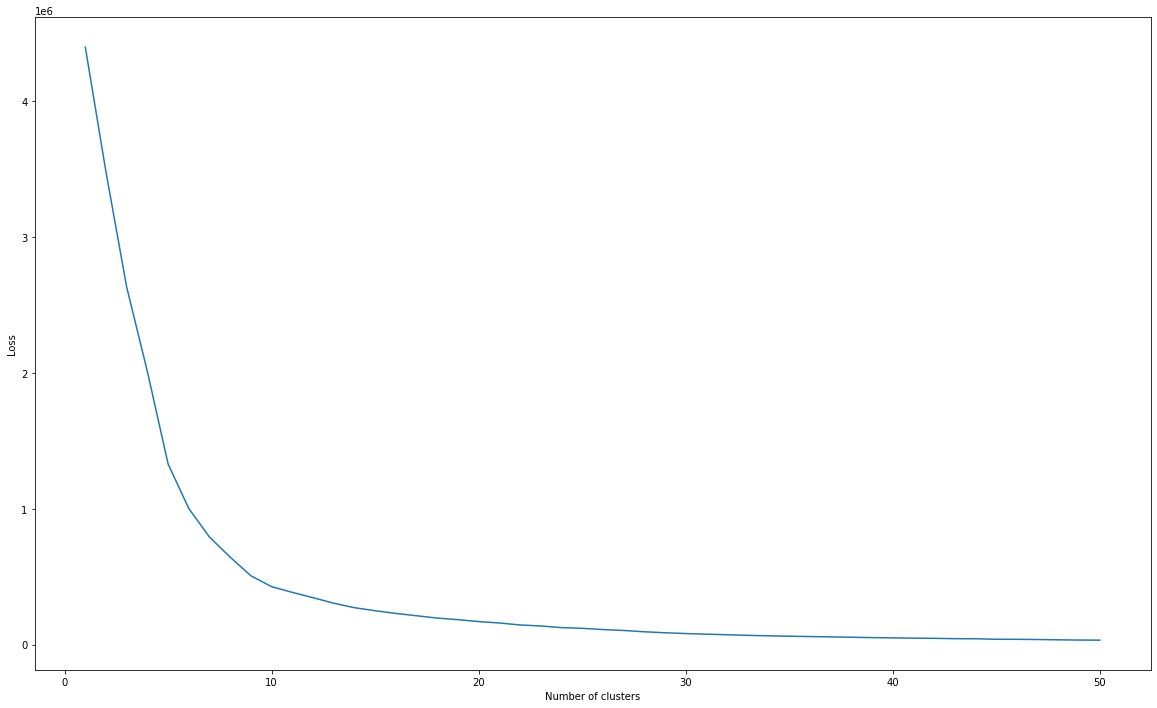

In [113]:
# Cluster numbers' decision - kmeans

k_max = 50

clusters = []
losses = []

X = trip_data[["duration_in_seconds", "age","gender","user_type_id","precip"]]

# Drop wrong or outlier values
X = X.drop(X[X.age > 200].index)   
scaler.fit(X)
X_scaled = scaler.transform(X)

# Find out the best K
for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")

#plt.savefig("./figs/clustering/kmeans.png") 
plt.show()

(0.0, 10.0)

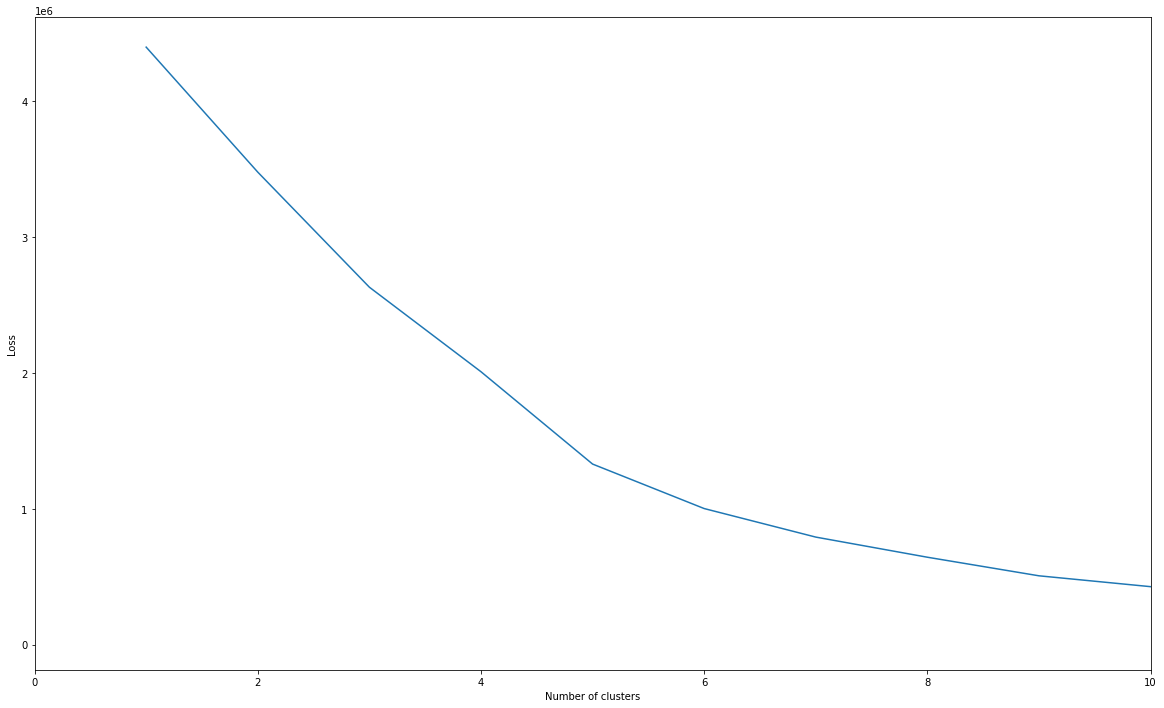

In [114]:
#Zoom in
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])
#plt.savefig("./figs/clustering/kmeansZoomIn.png")

From the results, it is obvious that 5-8 is the proper region.

/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


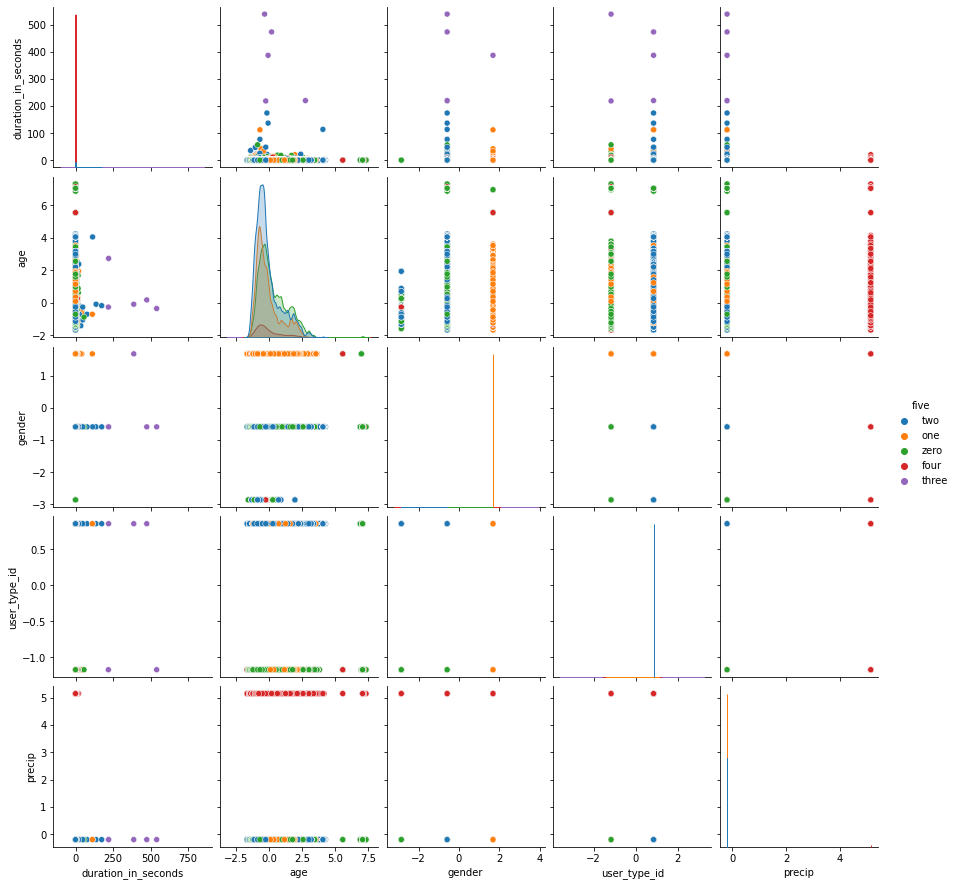

In [115]:
# We assume that in this case the smaller the number of clusters, the better, so we cluster all the trip data into 5 groups and show the result in pairplot
numbers = ["zero", "one", "two", "three","four"]
five_means = KMeans(n_clusters=5)
five_means.fit(X_scaled)
y = Clustering_dataset[["user_type"]]
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
trip_scaled_full = X_scaled_df
trip_scaled_full["five"] = five_means.predict(X_scaled)
trip_scaled_full["five"] = trip_scaled_full["five"].apply(lambda x: numbers[x])
pairplot = sns.pairplot(data=trip_scaled_full, hue="five")

#pairplot.fig.savefig("./figs/clustering/overviewWithK5.png") 

After several rounds of filtering, we finally identified "duration_in_seconds", "age","gender"," user_Type_id ", and "Precip" as the cluster demand patterns for each group and showed the differences in these values through Boxplot in order to summarize the characteristics of them.

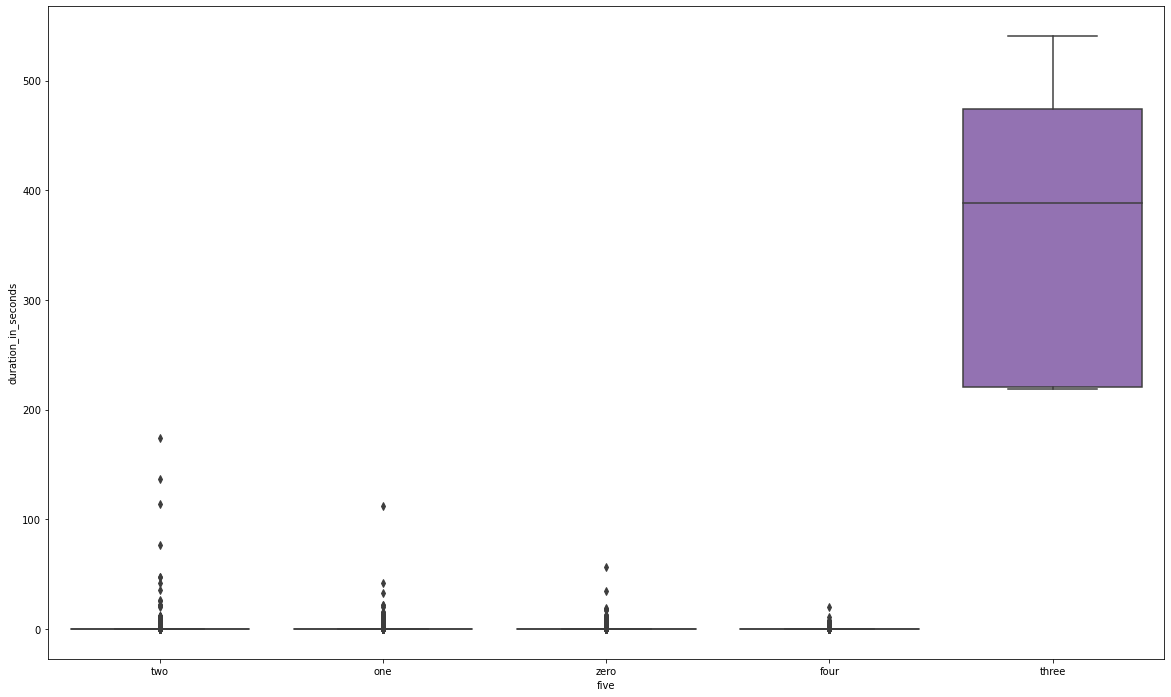

In [116]:
#Group 4 - long distance usage
boxplot = sns.boxplot(x="five", y="duration_in_seconds", data=trip_scaled_full)

#boxplot.get_figure().savefig('./figs/clustering/longDistance.png')

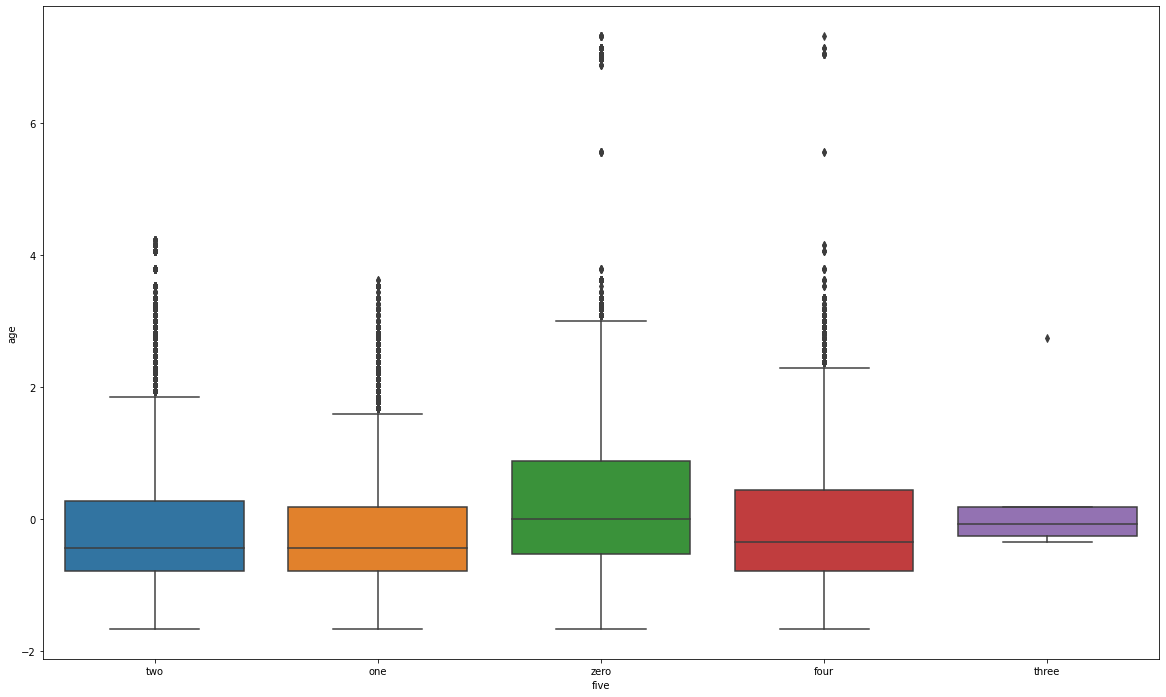

In [118]:
#Group 1 - elderly user
boxplot = sns.boxplot(x="five", y="age", data=trip_scaled_full)

#boxplot.get_figure().savefig('./figs/clustering/elderlyUser.png')

FileNotFoundError: [Errno 2] No such file or directory: './figs/clustering/maleUser.png'

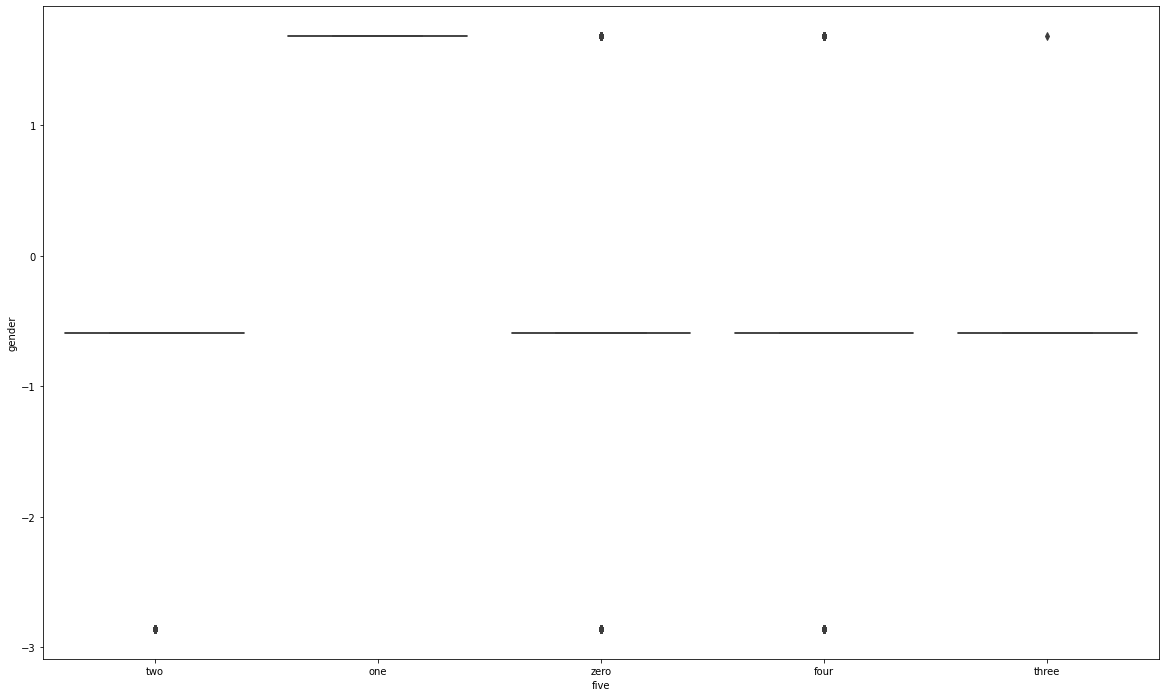

In [119]:
#Group 1 - male user
boxplot = sns.boxplot(x="five", y="gender", data=trip_scaled_full)

boxplot.get_figure().savefig('./figs/clustering/maleUser.png')

<BarContainer object of 5 artists>

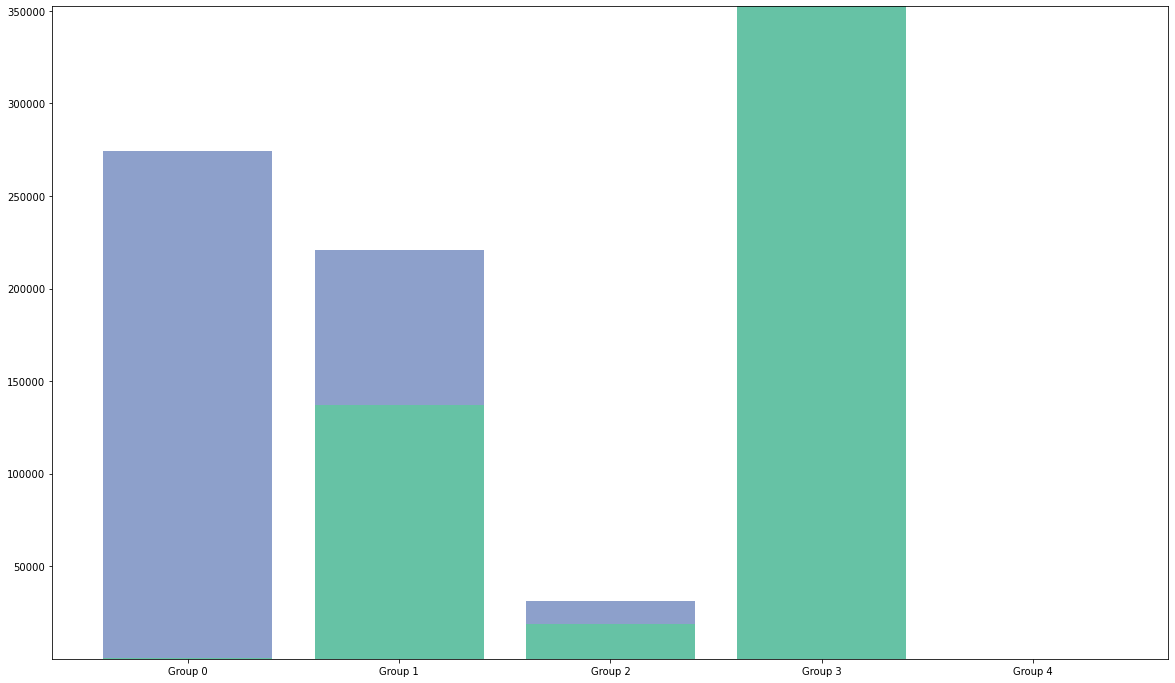

In [120]:
#Group 2 - subscriber & Group 0 - normal user

user_type_id = trip_scaled_full[['user_type_id', 'five']]

result_user_type = user_type_id.groupby(["five", "user_type_id"]).size().reset_index(name='counts')
#result_user_type

x = [1,2,3,4,5]
y = [271, 136963, 18955, 352379, 3]
y1 = [274174,84041,12349,0,2]

plt.bar(x, y, align="center", color="#66c2a5", tick_label=["Group 0", "Group 1", "Group 2", "Group 3", "Group 4"], label="Subscriber")
plt.bar(x, y1, align="center", bottom=y, color="#8da0cb", label="Customer")

<BarContainer object of 5 artists>

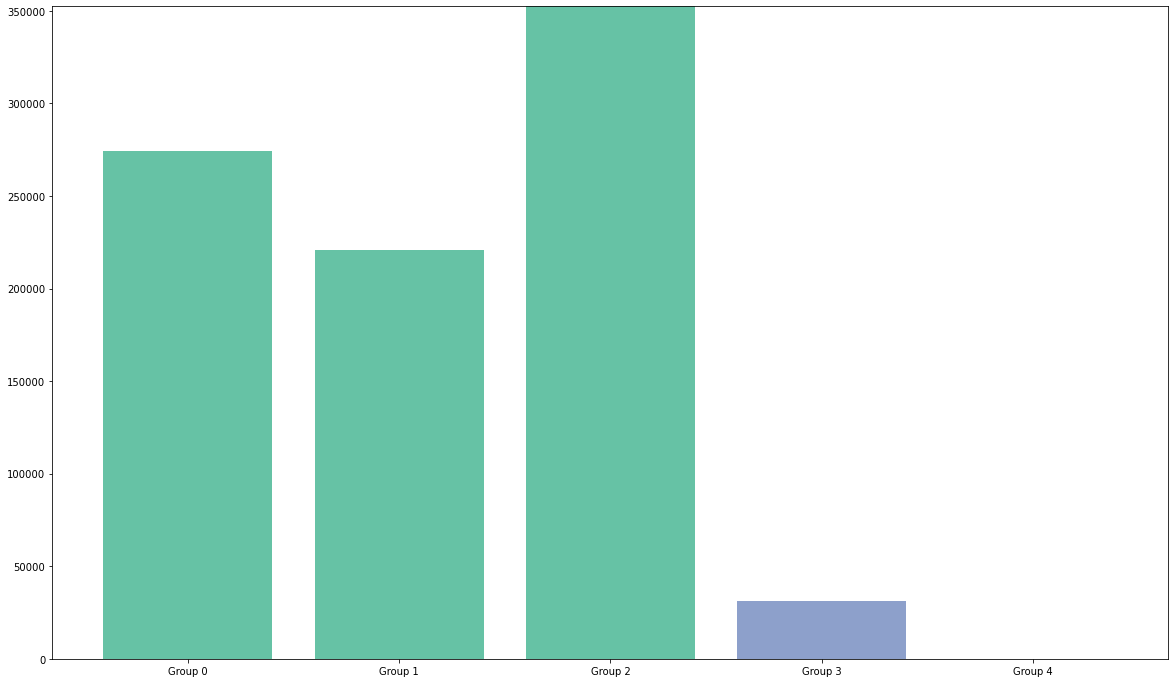

In [121]:
#Group 3 - Emergency users of extreme weather
precip = trip_scaled_full[['precip', 'five']]

result_pre = precip.groupby(["five", "precip"]).size().reset_index(name='counts')

x = [1,2,3,4,5]
y = [274445, 221004, 352379, 0, 5]
y1 = [0,0,0,31304,0]

plt.bar(x, y, align="center", color="#66c2a5", tick_label=["Group 0", "Group 1", "Group 2", "Group 3", "Group 4"], label="without Precip")
plt.bar(x, y1, align="center", bottom=y, color="#8da0cb", label="with Precip")

## Principal Component Analysis (PCA) 


In [122]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)
print(sum(pca.explained_variance_ratio_))

## 4 PC can only represent 84% of whole content. In conclusion, PCA is quite useless in this dataset.

0.8416805527912581


## Customer types summary

Customer type 0 --- "Ordinary users": Large age span; All were ordinary users; The average usage time is extremly short; Only use the bike when the weather is good.

Customer type 1 --- "Male users": Age generally young ordinary users; All were male; The average usage time is relatively short; Only use the bike when the weather is good.

Customer type 2 --- "Subscriber": All users are subscribers; Most of the usage time is relatively short, but the average usage time is longer than others except long distance users; Only use the bike when the weather is good; Age generally young.

Customer type 3 --- "Users in emergency": Large age span；The average usage time is extremly short；Only use the bike when the weather is rainy or snowy.

Customer type 4 --- "Long distance users": Age is concentrated in middle age; The average usage time is extremly long; Only use the bike when the weather is good.

# 3b: Locations Clustering

## Data Prep and Scaling 

In [123]:
# Data Processing (Use 'Ratio' to show the relationship between start and end of each station)
Clustering_basedataset_2 = station_data[["station_name","dock_number", "end_station_count","start_station_count","total_count"]]
X0 = Clustering_basedataset_2[["dock_number", "end_station_count","start_station_count","total_count"]]
X0["ratio"] = X0["start_station_count"]/X0["end_station_count"]
X0 = X0.drop(X0[X0.dock_number == -1].index)

# Select characteristics for cluster analysis
X1 = X0[["dock_number", "ratio", "total_count"]] 
scaler.fit(X1)
X_scaled_1 = scaler.transform(X1)

## K-Means

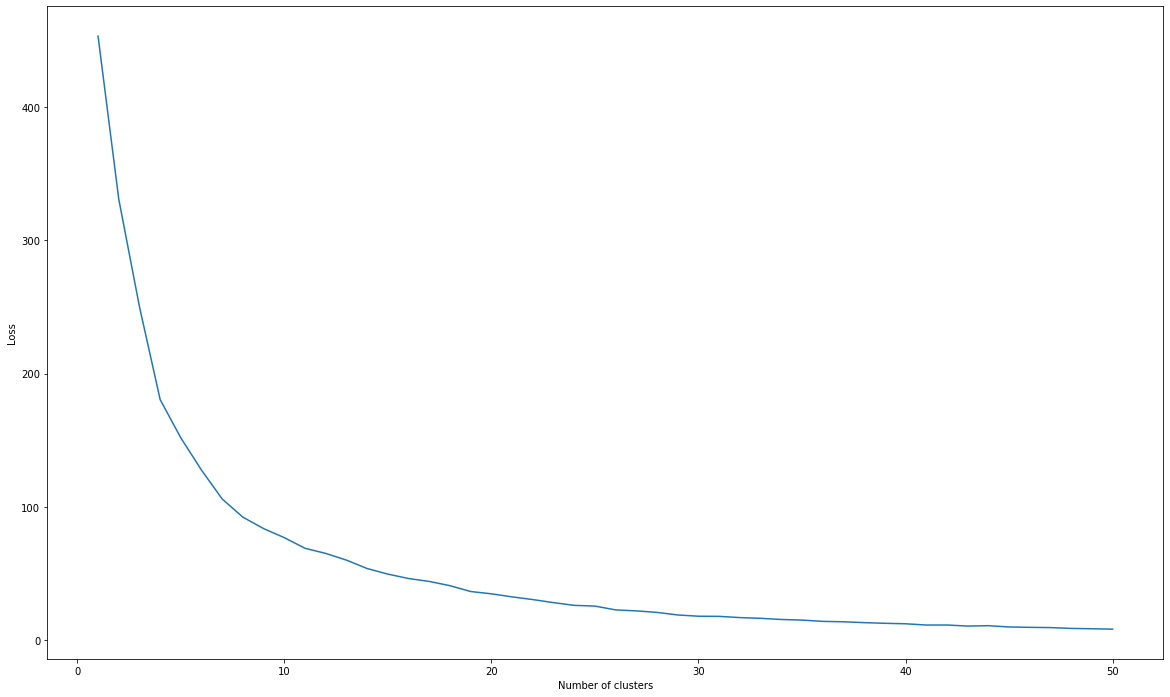

In [124]:
# Locations Clustering - kmeans' best K finding
k_max = 50

clusters1 = []
losses1 = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled_1)
    clusters1.append(k+1)
    losses1.append(model.inertia_)

plt.plot(clusters1, losses1)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")

#plt.savefig("./figs/clustering/LocationKmeans.png") 
plt.show()

(0.0, 10.0)

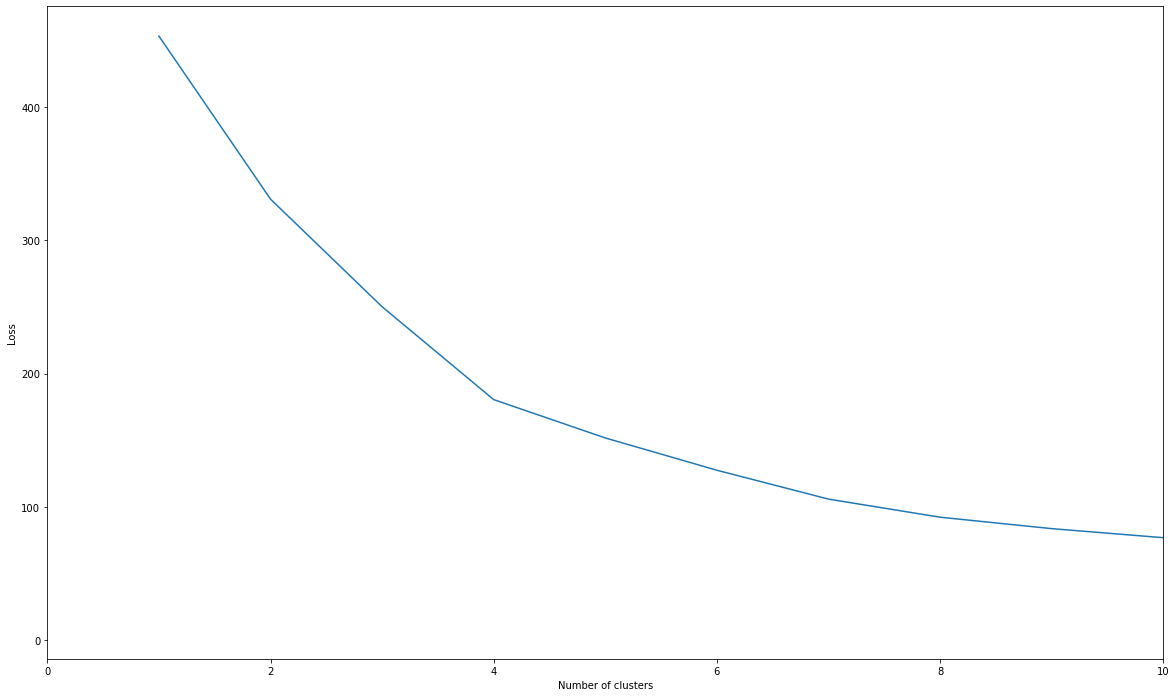

In [125]:
#Zoom in
plt.plot(clusters1, losses1)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])
#plt.savefig("./figs/clustering/LocationKmeansZoomIn.png")

From the results, it is obvious that 4-6 is the proper region. 

/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


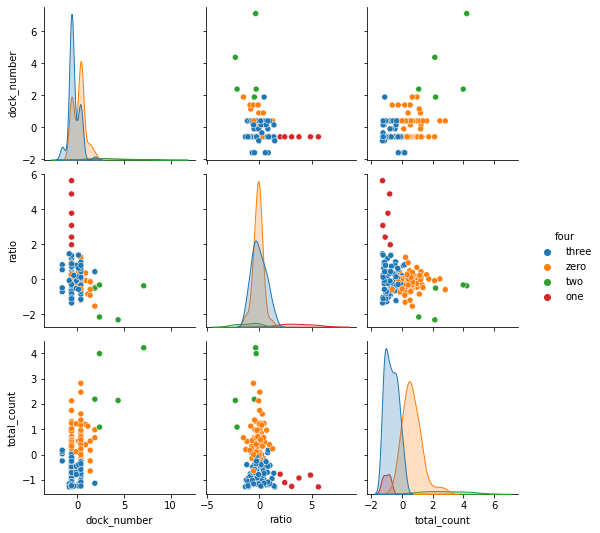

In [126]:
# We select 4 cluster groups here
numbers = ["zero", "one", "two", "three","four"]
four_means = KMeans(n_clusters=4)
four_means.fit(X_scaled_1)
X_scaled_1_df = pd.DataFrame(X_scaled_1, columns=X1.columns, index=X1.index)
station_scaled_full = X_scaled_1_df
station_scaled_full["four"] = four_means.predict(X_scaled_1)
station_scaled_full["four"] = station_scaled_full["four"].apply(lambda x: numbers[x])
pairplot = sns.pairplot(data=station_scaled_full, hue="four")

#pairplot.fig.savefig("./figs/clustering/locationClusteringK4.png") 

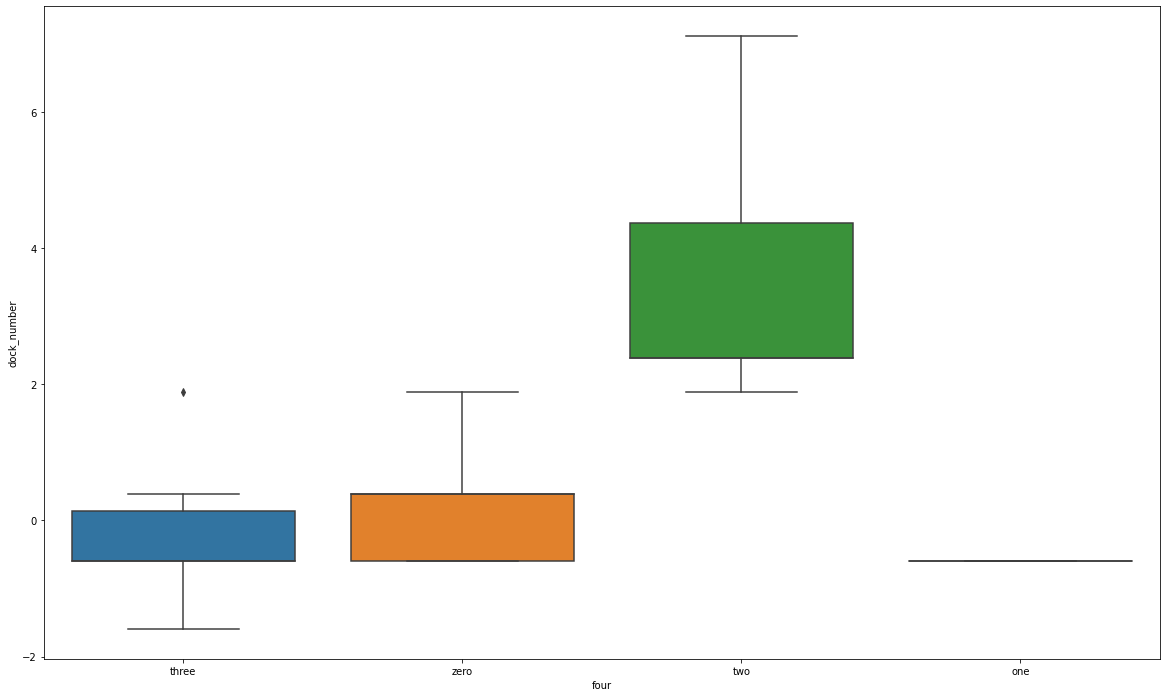

In [127]:
# Exploring Characteristics
boxplot = sns.boxplot(x="four", y="dock_number", data=station_scaled_full)

#boxplot.get_figure().savefig('./figs/clustering/dockNumber.png')

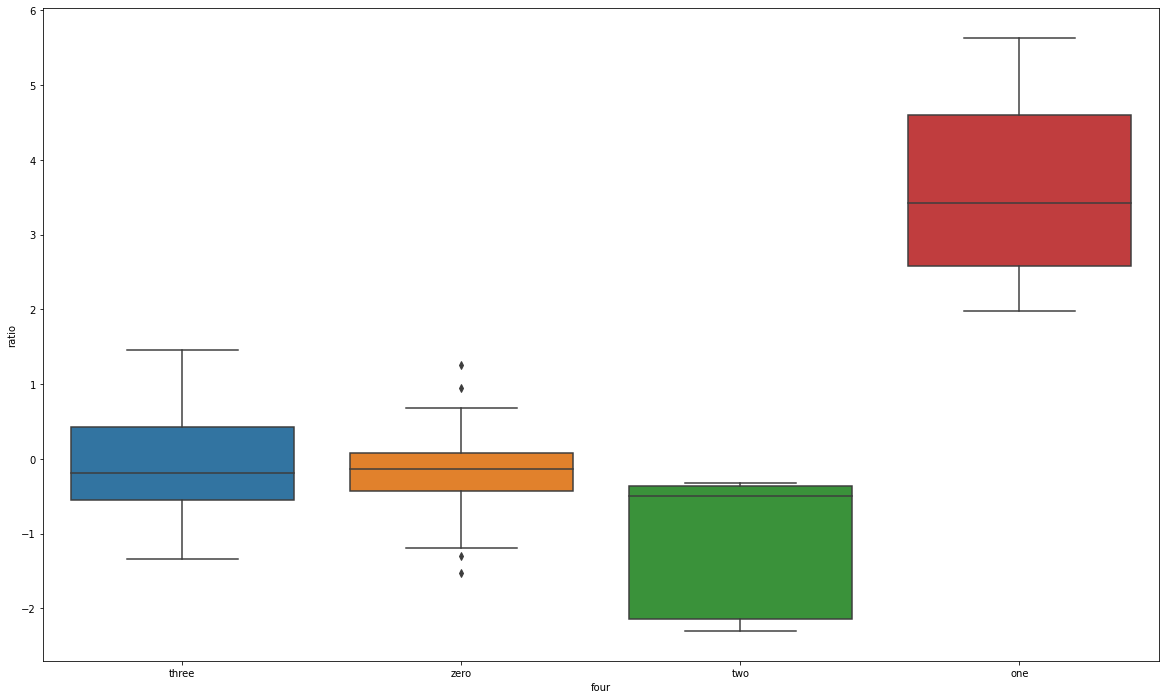

In [128]:
# Exploring Characteristics
boxplot = sns.boxplot(x="four", y="ratio", data=station_scaled_full)

#boxplot.get_figure().savefig('./figs/clustering/ratio.png')

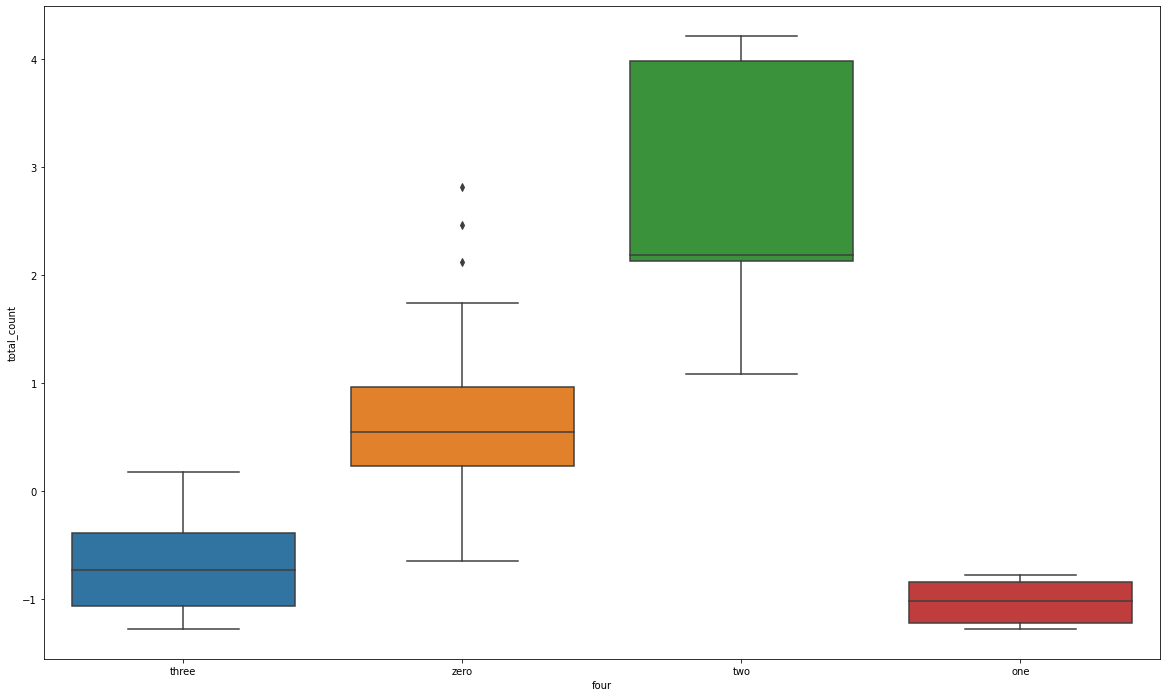

In [129]:
# Exploring Characteristics
boxplot = sns.boxplot(x="four", y="total_count", data=station_scaled_full)

#boxplot.get_figure().savefig('./figs/clustering/location_totalCount.png')

## PCA

In [130]:
## We also tried to use PCA here
pca1 = PCA(n_components=2)
X_pca_1 = pca1.fit_transform(X_scaled_1)
print(pca1.explained_variance_ratio_)
print(sum(pca1.explained_variance_ratio_))

[0.55296398 0.28013785]
0.8331018237835925


In [131]:
locations_pca = pd.DataFrame(X_pca_1, columns=["First PC", "Second PC"], index=X0.index)
locations_pca["Kinds"] = station_scaled_full["four"]
locations_pca.head()

First PC  Second PC  Kinds
2 -0.546048  -0.492032  three
3 -0.308636   0.226693   zero
4 -0.324940  -0.595106  three
5  0.215014   0.179419   zero
6 -0.100570  -1.399482  three

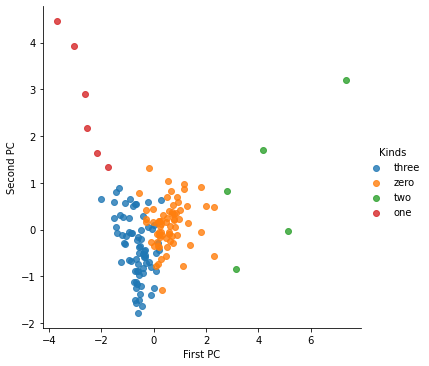

In [132]:
lmplot = sns.lmplot(x="First PC", y="Second PC", data=locations_pca, fit_reg=False, hue="Kinds")

#lmplot.fig.savefig('./figs/clustering/location_PC.png')

The result is quite similar to the former one, also the result of Hierarchical Clustering following.

## Clustering result shown by Geographic

In [133]:
# Function for plotting the clustered station data in a google maps iframe
Clustering_basedataset_2["station_type"] = station_scaled_full["four"]
# Set color
def set_station_type_color(row):
    if row["station_type"] == 'zero':
        return "black"
    elif row["station_type"] == 'one':
        return "green"
    elif row["station_type"] == 'two':
        return "red"
    else:
        return "blue"

Clustering_basedataset_2["station_type_color"] = Clustering_basedataset_2.apply(lambda row: set_station_type_color(row), axis=1)
#Clustering_basedataset_2

# Set radius
Clustering_basedataset_2["station_type_radius"] = 1

station_type_source = ColumnDataSource(Clustering_basedataset_2)
hover = HoverTool(tooltips = [('Station', '@station_name'), ('Type', '@station_type')])
p_station_type = gmap(API_KEY, map_options = gmap_options, title='Boston Bike Station Type Distribution',
               width=bokeh_width, height=bokeh_height, 
               tools=[hover, 'reset', 'wheel_zoom', 'pan']
              )
p_station_type.circle('lng', 'lat', size=10, alpha=0.4, 
               color='station_type_color', source=station_type_source)

show(p_station_type)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "x" value "lng", key "y" value "lat" [renderer: GlyphRenderer(id='1887', ...)]


## Location types summary

Location type 0 --- "Freezing stations": The number of bike stop points(Dock Number) of the station is extremely less; Few people use it; Usually only as a ending point.

Location type 1 --- "Relatively popular stations": The number of bike stop points (Dock Number) of the station is less; Numbers of users use it; Almost as often as a starting and ending point.

Location type 2 --- "Hot stations": The number of bike stop points (Dock Number) of the station is huge; All were ordinary users; Plenty of users use it; Usually as a starting point.

Location type 3 --- "Less popular stations": The number of bike stop points(Dock Number) of the station is less; Few people use it; Almost as often as a starting and ending point.

# 4: Prediction

## Preperation
In the next section, we will predict the next system wide hourly demand. 


**Clarification**: By hourly demand, we assume the count of trips taken in total over the next hour.

### Feature Extraction

Taking a step back to the data plots, we will take a look at the following features:

1. **Time of the day**: As we can see, the time of the day has a cyclical behaviour. each day, we seem to have some spikes at 9:00 and 17:00, higher trip counts at day than at night.
2. **Month of the year**: The summer months seem to have a higher impact towards the tripcounts. This is probably seasonal, but this cannot be ultimately shown with just one year.
- **Weekday**: We see a higher trip count during the week than on the weekends, so we have a weekly seasonality here.
- **precip**: Precip seems to have a big impact towards people willing to take a riding trip.
- **Temparature**: Colder temparatures have a lower ride count.

all of these features seem to play a role when we are taking the amount of trips taken into account.

### Which Model to use?

The data appears to be cyclical and non-linear, so building a linear Framework on top of it doesn't seem make any sense. 
- **Multipolinomial Models** seem to be more rational with the data, maybe even some sort of sin-Derivative, as it seems to resemble the monts in a year / Hours in a day the best, as for temparature we probably need some multipolynomial higher degree (maybe 5-10), as it seems to have a turning point (similar to the electricity usage in the lecture)
- **ARIMA Models**: seem to be very intuitive, as the time-dependend part of the data (hours in a day, day in a week) seems to play an important role. As we can effectively model seasonality here, this will be our second attempt of predicting the demand.
- **LSTM Models**: As we have multivariate features (Time dependend of the past & temparature + precip) we will use a LSTM model to make use of both of these feature types. 

### How to measure the model

To try and compare the model, we will let each model compare the last 500 hours of the year and calculate the RSME (Root squared mean error) and R2 for each model. 

In [134]:
def eval_result(predicted_values, actual_values):

    print(f"Root Mean Squared Error Very Short term: {mean_squared_error(predicted_values[:1], actual_values[:1], squared=False)}")
    print(f"R2 Very Short term: {r2_score(predicted_values[:2], actual_values[:2])}")
    print()
    print(f"Root Mean Squared Error Short term: {mean_squared_error(predicted_values[:10], actual_values[:10], squared=False)}")
    print(f"R2 Short term: {r2_score(predicted_values[:10], actual_values[:10],)}")
    print()
    print(f"Root Mean Squared Error Mid term: {mean_squared_error(predicted_values[:100], actual_values[:100], squared=False)}")
    print(f"R2 Mid term: {r2_score(predicted_values[:100], actual_values[:100])}")
    print()
    print(f"Root Mean Squared Error Long term: {mean_squared_error(predicted_values, actual_values, squared=False)}")
    print(f"R2 Long term: {r2_score(predicted_values, actual_values)}")
    print()

### Root Benchmark
The root benchmark we will take is the data shifted by an hour (so basically just taking the exact value of the last hour), which will provide us with a RMSE score of about 90:

In [135]:
print(mean_squared_error(ARIMA_data[1:-1], ARIMA_data.shift()[1:-1], squared=False))

89.90681255290822


### Poly Model
The following code will construct and fit the polynomial model.

This model takes the month, hour and day as independant variables, so it is the only model, where it is important to randomize the variables

Following steps have been taken: 
- we seperate the features into one input each (hour of the day = 1 input, day of the week = 1 input, ...)
- we then use the PolynomialFeatures function, to make them polylinear. During a stresstest, we found out that a degree of 5 gave the best results
- then we check the RMSE for the models with 10 KFolds.
- finally we create the model and have a look at the plot on how good it performs

In [136]:
#JD
def create_test_scenarios(poly_degree):
    scaler = StandardScaler()

    months = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["month"].to_frame().to_numpy()))
    weekdays = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["weekday"].to_frame().to_numpy()))
    hours = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["hour"].to_frame().to_numpy()))
    precip = Poly_data["precip"]
    min_temp = PolynomialFeatures(degree=poly_degree).fit_transform(scaler.fit_transform(Poly_data["min_temp"].to_frame().to_numpy()))

    hourly_demand = Poly_data["hourly_demand"].to_frame().to_numpy()

    months_df = pd.DataFrame(months, columns=[f"months_poly_{n}" for n in range(0, len(months[0]))])
    weekdays_df = pd.DataFrame(weekdays, columns=[f"weekdays_{n}" for n in range(0, len(weekdays[0]))])
    hours_df = pd.DataFrame(hours, columns=[f"hours_{n}" for n in range(0, len(hours[0]))])
    precip_df = pd.DataFrame(precip, columns=["precip"])
    min_temp_df = pd.DataFrame(min_temp, columns=[f"min_temp_{n}" for n in range(0, len(min_temp[0]))])
    
    full_data = pd.merge(months_df, weekdays_df, left_index=True, right_index=True)
    full_data = full_data.merge(hours_df, left_index=True, right_index=True)
    full_data = full_data.merge(precip_df, left_index=True, right_index=True)
    
    return full_data.merge(min_temp_df, left_index=True, right_index=True), hourly_demand



# Creates a Regression model with a feature Layer
def prediction_model(feature_layer, num_layers):
    feature_number = len(pd.DataFrame(feature_layer).columns)
    model= tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=feature_number, input_shape=(feature_number,)))
    # Create "num_layer" layers with each one getting smaller by the index of layer (First hidden layer => /2, Second hidden layer => /3, ....)
    [model.add(tf.keras.layers.Dense(units=feature_number//(number_of_layer + 1))) for number_of_layer in range(1, num_layers)]
    model.add(tf.keras.layers.Dense(units=1)) 
    model.compile(optimizer="adam",loss="mean_squared_error",metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model   

# Feed a dataset into the model in order to train it.
def train_model(model, X, Y, epochs, batch_size):
    history = model.fit(x=X, y=Y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=0)
    epochs = history.epoch
    rmse = pd.DataFrame(history.history)["root_mean_squared_error"]
    return epochs, rmse   

def create_single_model(features, labels, epochs, batch_size, num_layers):
    model = prediction_model(features, num_layers)
    train_model(model, features, labels , epochs, batch_size)
    return model



def eval_model(features, labels, epochs, batch_size, num_layers):
    kfold = KFold(n_splits=10)
    fold_info = []
    for train, test in kfold.split(features, labels):
        print("kfold finished!")
        model = prediction_model(features, num_layers)
        
        train_model(model, features[train], labels[train] , epochs, batch_size)
        
        scores = model.evaluate(features[test], labels[test], verbose=0)
        fold_info.append(scores)
    return pd.DataFrame(fold_info)


next, we want to check, if it makes sense to have each polynomaial concattenated with each polynomaial ([a, b]^2 -> [1, a, b, a^2, ab, b^2], High_poly), or just the polynomials of the original features ([a, b]^2 -> [1, a, b, a^2, b^2], Low_poly
)

In [137]:

Poly_scaler = StandardScaler()

Poly_data_copy = Poly_data.copy()

Poly_data_label = Poly_data_copy.pop("hourly_demand")
Poly_data_features = PolynomialFeatures(degree=5).fit_transform(Poly_scaler.fit_transform(Poly_data_copy))

poly_data_features_low_poly, poly_data_label_low_poly = create_test_scenarios(5)

High_poly_eval = eval_model(Poly_data_features, Poly_data_label, 100, 200, 1)
Low_poly_eval = eval_model(poly_data_features_low_poly.values, poly_data_label_low_poly, 100, 200, 1)

print(High_poly_eval)
print(Low_poly_eval)

print(High_poly_eval.mean()[1])
print(Low_poly_eval.mean()[1])


kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
kfold finished!
              0           1
0  47734.460938  218.482178
1   5609.408203   74.895981
2  11057.928711  105.156685
3  18484.160156  135.956467
4  16943.968750  130.169006
5  19200.125000  138.564514
6  16541.242188  128.612762
7  15263.421875  123.545219
8   9540.350586   97.674721
9  19682.310547  140.293655
              0           1
0  16541.808594  128.614960
1   9058.248047   95.174828
2  10785.650391  103.853989
3  18916.220703  137.536255
4  20775.216797  144.136108
5  22502.228516  150.007431
6  18604.154297  136.397049
7  16812.339844  129.662415
8  10140.571289  100.700401
9   7016.268066   83.763168
129.3351188659668
120.98466033935547


Although the High-Poly model does have the best score (77), the Low-Poly model does perform better on average than the High-Poly model.

Now we create the model without the KFold test, to use it to make predictions. As this is the only model, that is not dependend on the time but only on the single components of the datetime, this is the only model where we can use the KFold test. 

The epochs and batchsizes were chosen to have a reasonable runtime.

In [138]:
model = create_single_model(poly_data_features_low_poly[:-500], poly_data_label_low_poly[:-500], 1000, 200, 1)
poly_predictions = model.predict(poly_data_features_low_poly[-500:])

Root Mean Squared Error Very Short term: 2.8140709400177
R2 Very Short term: 0.29973715424181113

Root Mean Squared Error Short term: 88.52382944206369
R2 Short term: -0.7308842129699977

Root Mean Squared Error Mid term: 67.75222754800788
R2 Mid term: 0.4446861756682914

Root Mean Squared Error Long term: 83.2476223254468
R2 Long term: 0.1806259591313205



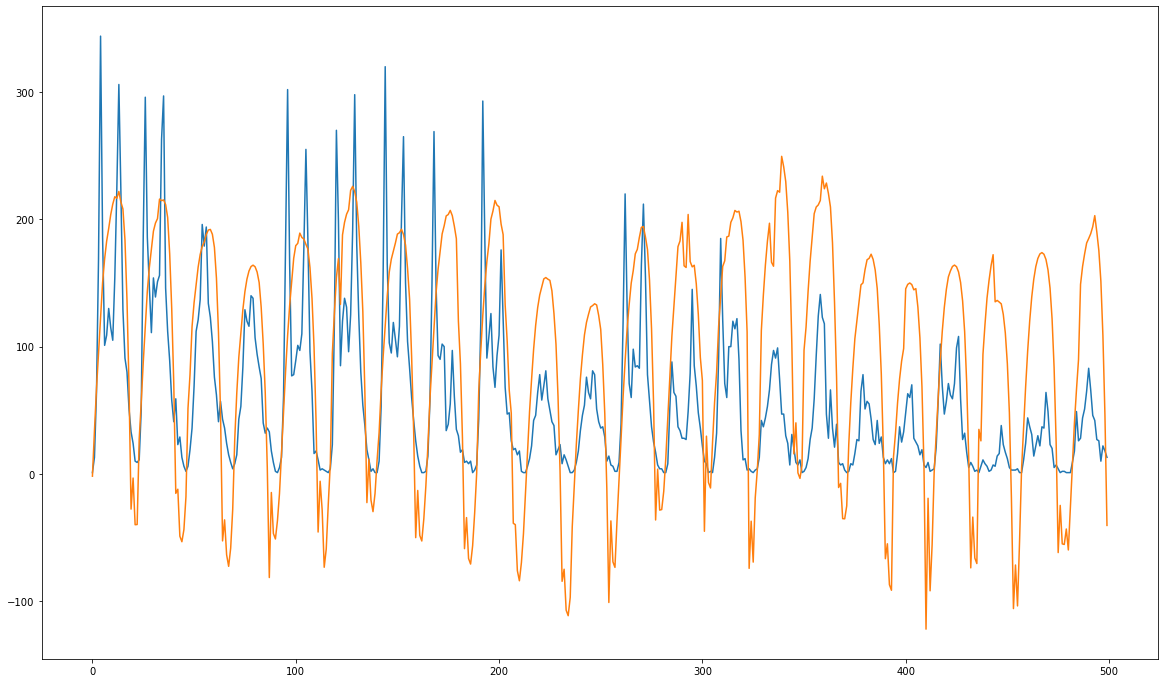

In [139]:
plt.plot(poly_data_label_low_poly[-500:])
plt.plot(poly_predictions)


#plt.savefig('./figs/predictions/polymodel.png')

eval_result(poly_predictions, poly_data_label_low_poly[-500:])

We can see, that the model performs fairly bad overall, with RMSEs even worse than just taking the last hour's value.

### ARIMA model
The following code will construct and fit the ARIMA model.

Following steps have been taken: 
- First we identify AR and MA using ACF and PACF Plots
- Next we model ARIMA with a Seasonality of 24 (hours in a day)
- Then we add externel features (precip) to the model to check if it performs better
- Then we use the .append() method, to have a walk forward simulation of the model, appending the current actual demand after each timestep

/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


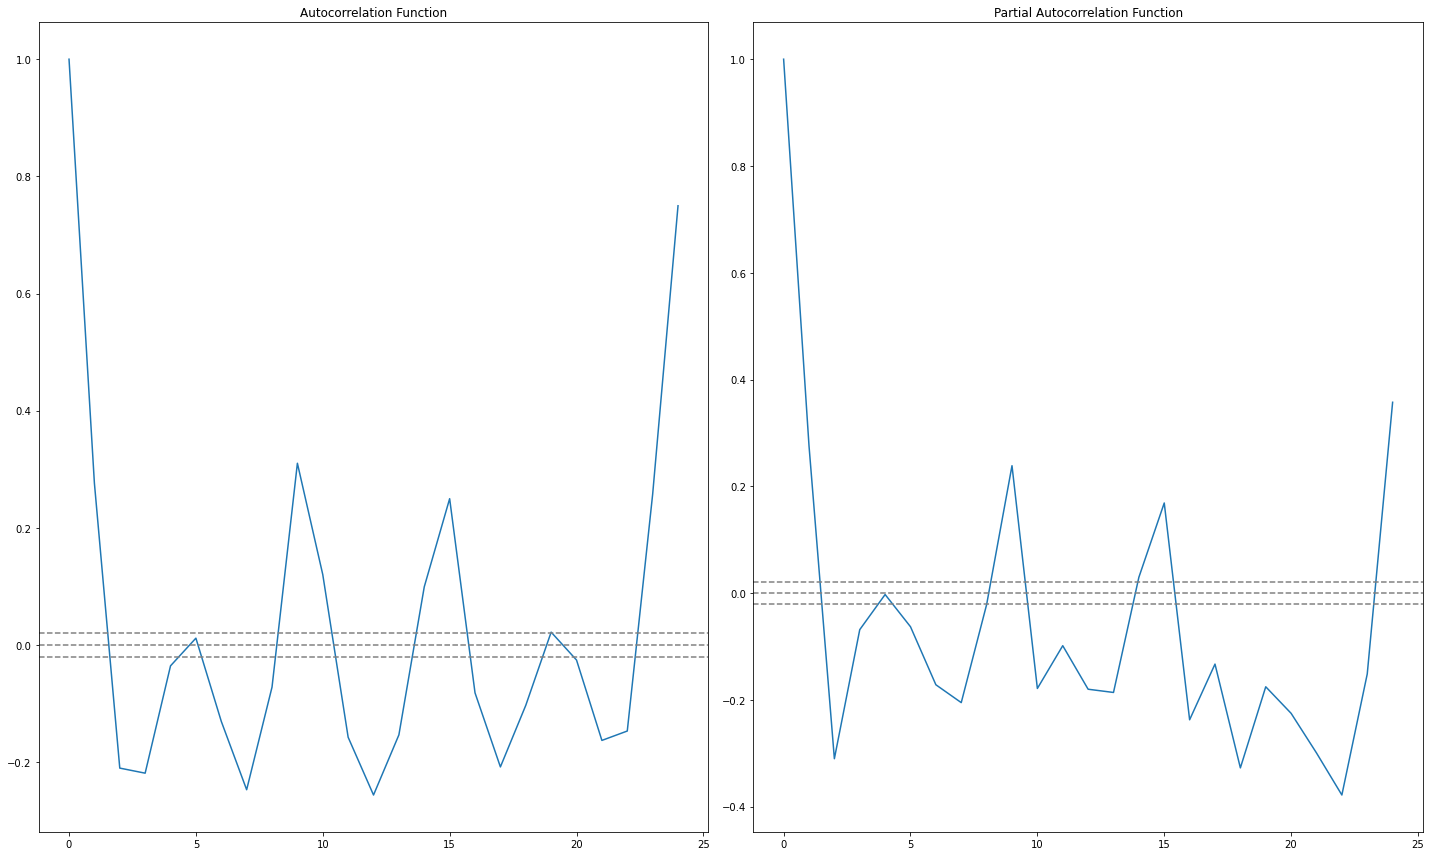

In [140]:
ARIMA_shift = ARIMA_hours - ARIMA_hours.shift()
lag_acf = acf(ARIMA_shift[1:], nlags=24)
lag_pacf = pacf(ARIMA_shift[1:], nlags=24, method='ols')


#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ARIMA_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ARIMA_shift)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ARIMA_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ARIMA_shift)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#plt.savefig('./figs/predictions/arima.png')


Here we can see, the optimal P and Q parameters are 2, as those are the values, where the graph crosses the optimal interval (dotted lines).

/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


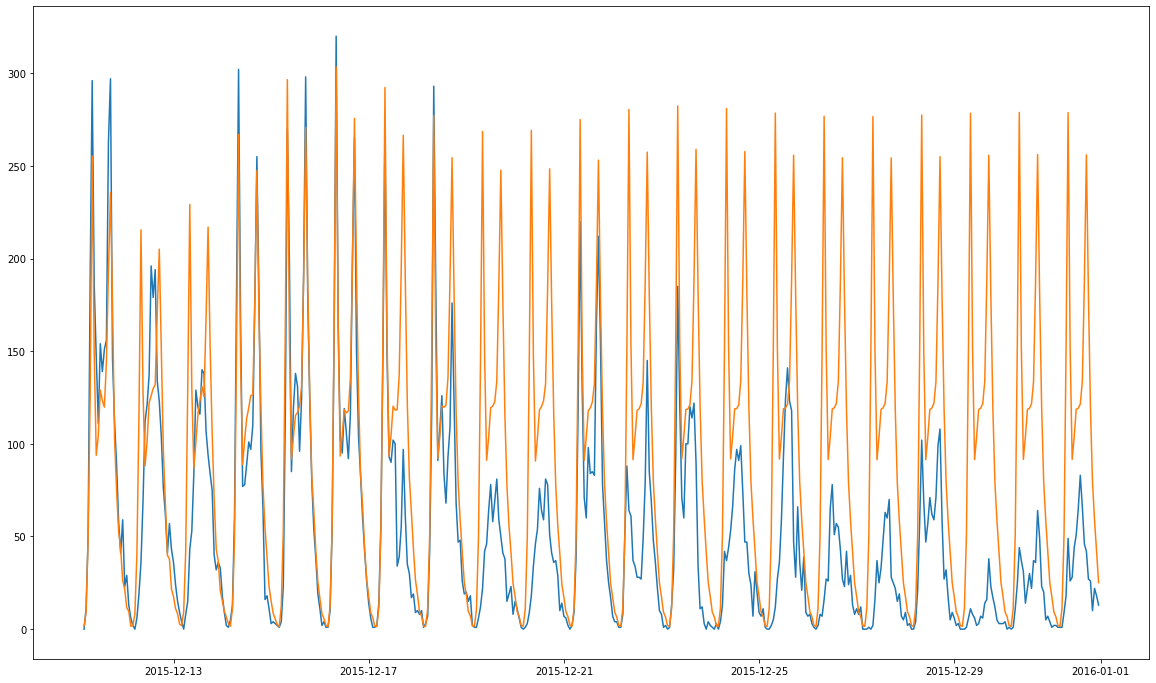

In [141]:
#We can see, that the optimal Order here is 2 as well.
#As we have a seasonial interval of 24 hours in a day, we take PDQs of (2,1,2,24)
model_normal = ARIMA(ARIMA_hours[:-500], seasonal_order=(2,1,2,24))
results_ARIMA_hours_normal = model_normal.fit()

#Lets polot the prediction agains the real data
plt.plot(ARIMA_hours[-500:])
plt.plot(results_ARIMA_hours_normal.forecast(500))

#plt.savefig('./figs/predictions/arima.png')

Her we can see, that the model picks up the 24h seasonality fairly well, but has problems with the weekly seasonality,.

In [142]:
ARIMA_default = results_ARIMA_hours_normal.forecast(500).values
ARIMA_actual = ARIMA_hours[-500:]

eval_result(ARIMA_default, ARIMA_actual)

Root Mean Squared Error Very Short term: 1.6824392857540897
R2 Very Short term: 0.7702253399698582

Root Mean Squared Error Short term: 32.66938947950967
R2 Short term: 0.7820832705290803

Root Mean Squared Error Mid term: 43.31905913462467
R2 Mid term: 0.6156945654391857

Root Mean Squared Error Long term: 73.45667984277337
R2 Long term: 0.06868542194717853



The model seems to already perform much better than the polynomial model and the "only shift"-variant. Especially the short term prediction seems very accurate.

In the ARIMA model, it is possible to add external influences, that do not have anything to do with the time series data. in the next example we will try to imporove the model by taking the precip (for future improvements, temparature as well) into account.

#### With PRECIP:

/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/patrickniebergall/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


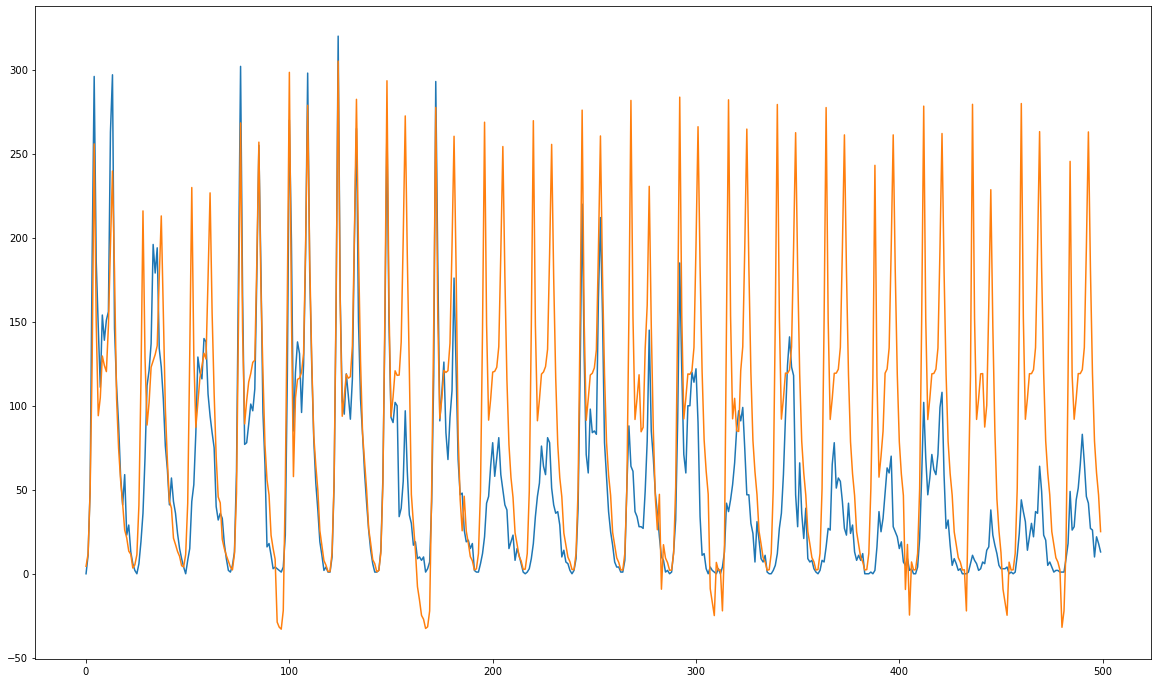

In [143]:
#We can see, that the optimal Order here is 2 as well.
#As we have a seasonial interval of 24 hours in a day, we take PDQs of (2,1,2,24)

train_precip_values = pd.DataFrame(full_hours["precip"])[:-500]
test_precip_values = pd.DataFrame(full_hours["precip"])[-500:]

model_precip = ARIMA(ARIMA_hours[:-500], train_precip_values, seasonal_order=(2,1,2,24))
results_ARIMA_hours_precip = model_precip.fit()

ARIMA_precip = results_ARIMA_hours_precip.forecast(500, exog=test_precip_values).values
ARIMA_actual = ARIMA_hours[-500:].values

#Lets polot the prediction agains the real data
plt.plot(ARIMA_actual)
plt.plot(ARIMA_precip)

#plt.savefig('./figs/predictions/arimaWithPrecip.png')

In [144]:
eval_result(ARIMA_precip, ARIMA_actual)

Root Mean Squared Error Very Short term: 4.423924274303374
R2 Very Short term: 0.27176334711729155

Root Mean Squared Error Short term: 32.43410077482918
R2 Short term: 0.7816276024051432

Root Mean Squared Error Mid term: 44.41285660932697
R2 Mid term: 0.6253828295671034

Root Mean Squared Error Long term: 72.1589868280185
R2 Long term: 0.1558589879436062



Run 0 of 30
Values: [0.] __ Precip: [0]
predicted=4.423924, expected=0.000000, time=9.375372
------------------------------------------
Run 1 of 30
Values: [11.] __ Precip: [0]
predicted=11.908219, expected=11.000000, time=8.696633
------------------------------------------
Run 2 of 30
Values: [50.] __ Precip: [0]
predicted=48.897622, expected=50.000000, time=5.451532
------------------------------------------
Run 3 of 30
Values: [188.] __ Precip: [0]
predicted=125.619715, expected=188.000000, time=5.460657
------------------------------------------
Run 4 of 30
Values: [296.] __ Precip: [0]
predicted=255.862572, expected=296.000000, time=4.994835
------------------------------------------
Run 5 of 30
Values: [186.] __ Precip: [0]
predicted=149.417712, expected=186.000000, time=4.470466
------------------------------------------
Run 6 of 30
Values: [147.] __ Precip: [0]
predicted=94.086658, expected=147.000000, time=4.162780
------------------------------------------
Run 7 of 30
Values:

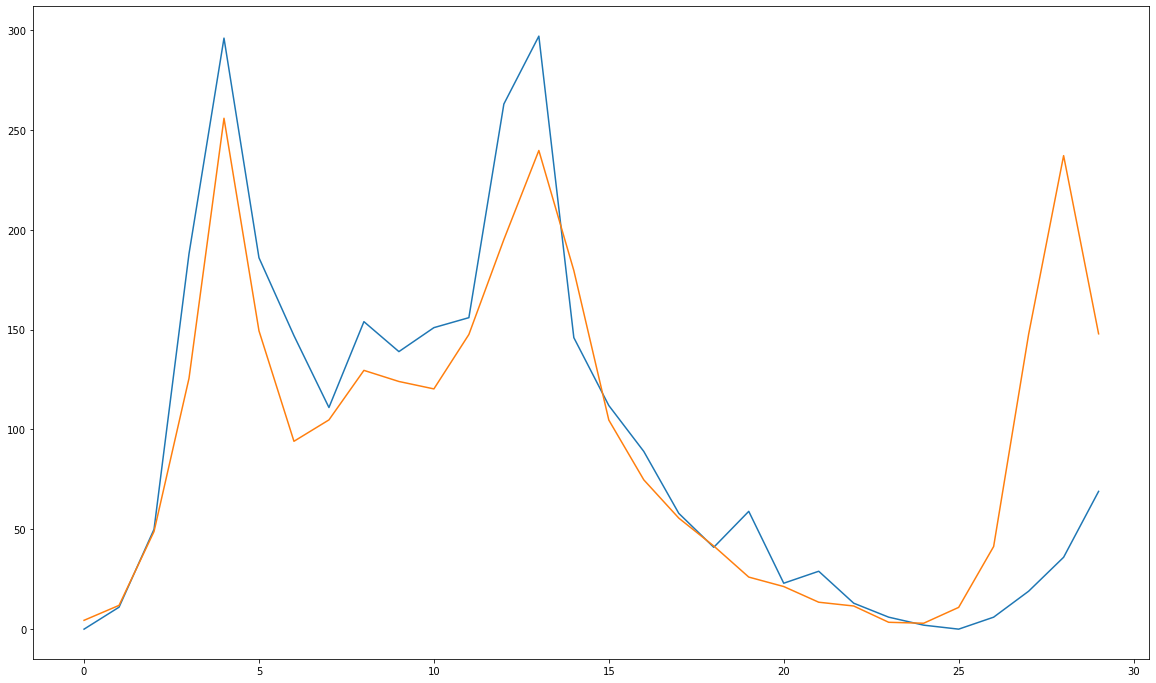

In [145]:
test_set= ARIMA_hours[-500:-470]
predictions = list()

for t in range(30):
    print(f"Run {t} of {len(test_set)}")
    start_time = time.time()
    print( f"Values: {test_set.iloc[t].values} __ Precip: {test_precip_values.values[t]}")
    output = results_ARIMA_hours_precip.forecast(1, exog=test_precip_values.values[t])[0]
    predictions.append(output)

    results_ARIMA_hours_precip = results_ARIMA_hours_precip.append(test_set.iloc[t].values, test_precip_values.values[t])
    print('predicted=%f, expected=%f, time=%f' % (output, test_set.iloc[t], time.time() - start_time))
    print("------------------------------------------")
    
plt.plot(test_set.values)
plt.plot(predictions)

#plt.savefig('./figs/predictions/arimaWithAdjustment.png')

plt.show()

In [148]:
print(f"Root Mean Squared Error Very Short term: {mean_squared_error(predictions, test_set.values, squared=False)}")
print(f"R2 Very Short term: {r2_score(predictions, test_set.values)}")


Root Mean Squared Error Very Short term: 53.7797505309709
R2 Very Short term: 0.4953265495697742


### LSTM Model
The following code will construct and fit the ARIMA model.

**Following steps have been taken:**
- Prepare the incoming dataset for the LSTM Layer - (add features and label from the previous t timesteps to the data)
- create the Model with 1 past timeset. 
- optimize the model with past 24 timesets (for the last 24 hours)

**Short description of the shape preparation:**

LSTM Layers expect an input of shape (samples, timesteps, features), so basically for each sample used to train/predict, the layer expects t timesteps with the corresponding features at timestep t. This means, for 1 timestep (i.e. 1 hour) we will have the features for (t-1) as input. for 24h we will have (t-24), (t-23), ... (t-1) as an input.

In [149]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
def prepare_lstm_dataset(dataset, scaler, n_hours=1):
	values = dataset.values
	values = values.astype('float32')
	scaled = scaler.fit_transform(values)

	reframed = series_to_supervised(scaled, n_hours, 1)
	# drop columns we don't want to predict
	
	return reframed

def LSTM_test_train_feature_label_split(data, test_amount):
	train = data[:test_amount, :]
	test = data[test_amount:, :]

	train_X, train_y = train[:, :-1], train[:, -1]
	test_X, test_y = test[:, :-1], test[:, -1]

	train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
	test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
 
	return train_X, train_y, test_X, test_y


def revert_LSTM_shaping(X_shape, Y_shape, yhat, scaler):
	test_X = X_shape.reshape((X_shape.shape[0], X_shape.shape[2]))
	test_y = Y_shape.reshape((len(Y_shape), 1))

	# invert scaling for forecast
	inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
	inv_yhat = scaler.inverse_transform(inv_yhat)
	prediction = inv_yhat[:,0]
	# invert scaling for actual
	inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
	inv_y = scaler.inverse_transform(inv_y)
	actual = inv_y[:,0]

	return prediction, actual

def create_LSTM_model(LSTM_input_shape):
	model = tf.keras.models.Sequential()
	model.add(LSTM(50, input_shape=LSTM_input_shape))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
	return model
 

def fit_LSTM_model(model, features, labels, epochs=50, batch_size=72):
	return model.fit(features, labels, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)	


LSTM_scaler = MinMaxScaler(feature_range=(0, 1))
# split into train and test sets
reframed = prepare_lstm_dataset(LSTM_data, LSTM_scaler)
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
values = reframed.values

train_X, train_y, test_X, test_y = LSTM_test_train_feature_label_split(values, -500)

model = create_LSTM_model((train_X.shape[1], train_X.shape[2]))

fit_LSTM_model(model, train_X, train_y)

# make a prediction
LSTM_normalized_prediction = model.predict(test_X)

LSTM_prediction, LSTM_actual = revert_LSTM_shaping(test_X, test_y, LSTM_normalized_prediction, LSTM_scaler)


Epoch 1/50
115/115 - 3s - loss: 0.0182 - root_mean_squared_error: 0.1348 - 3s/epoch - 26ms/step
Epoch 2/50
115/115 - 0s - loss: 0.0118 - root_mean_squared_error: 0.1087 - 155ms/epoch - 1ms/step
Epoch 3/50
115/115 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0940 - 219ms/epoch - 2ms/step
Epoch 4/50
115/115 - 0s - loss: 0.0085 - root_mean_squared_error: 0.0922 - 192ms/epoch - 2ms/step
Epoch 5/50
115/115 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0917 - 164ms/epoch - 1ms/step
Epoch 6/50
115/115 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0912 - 179ms/epoch - 2ms/step
Epoch 7/50
115/115 - 0s - loss: 0.0082 - root_mean_squared_error: 0.0907 - 180ms/epoch - 2ms/step
Epoch 8/50
115/115 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0902 - 209ms/epoch - 2ms/step
Epoch 9/50
115/115 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0896 - 193ms/epoch - 2ms/step
Epoch 10/50
115/115 - 0s - loss: 0.0079 - root_mean_squared_error: 0.0891 - 158ms/epoch - 1ms/step
Epoch 11/50
115/115 -

As we can see, the mean squared Error is lower than that of the previous model, and when plotting, we can see, that the prediction data does have a similar structure than the original data:

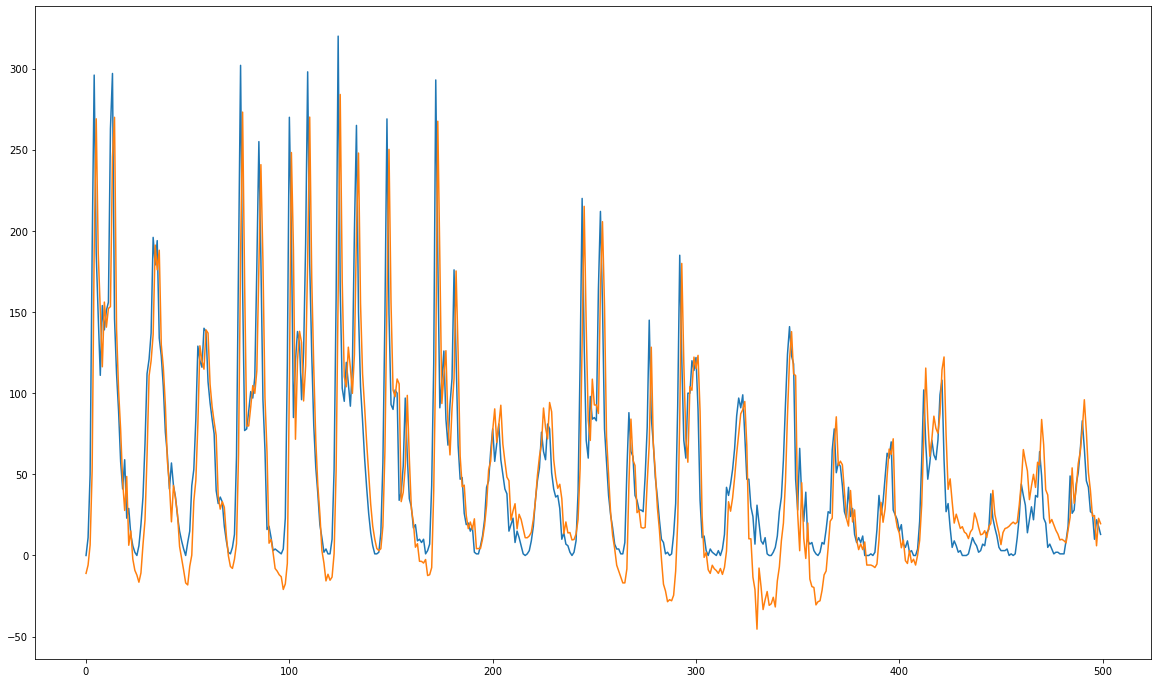

In [150]:
#print(mean_squared_error(LSTM_prediction, LSTM_actual, squared=False))
plt.plot(LSTM_actual, label="actual")
plt.plot(LSTM_prediction, label="prediction")

#plt.savefig('./figs/predictions/LSTM.png')

But upon taking a closer look, we can see, that the data is mainly just shifted.

Better than the real "shifted" data, but thats someting worth to improve.

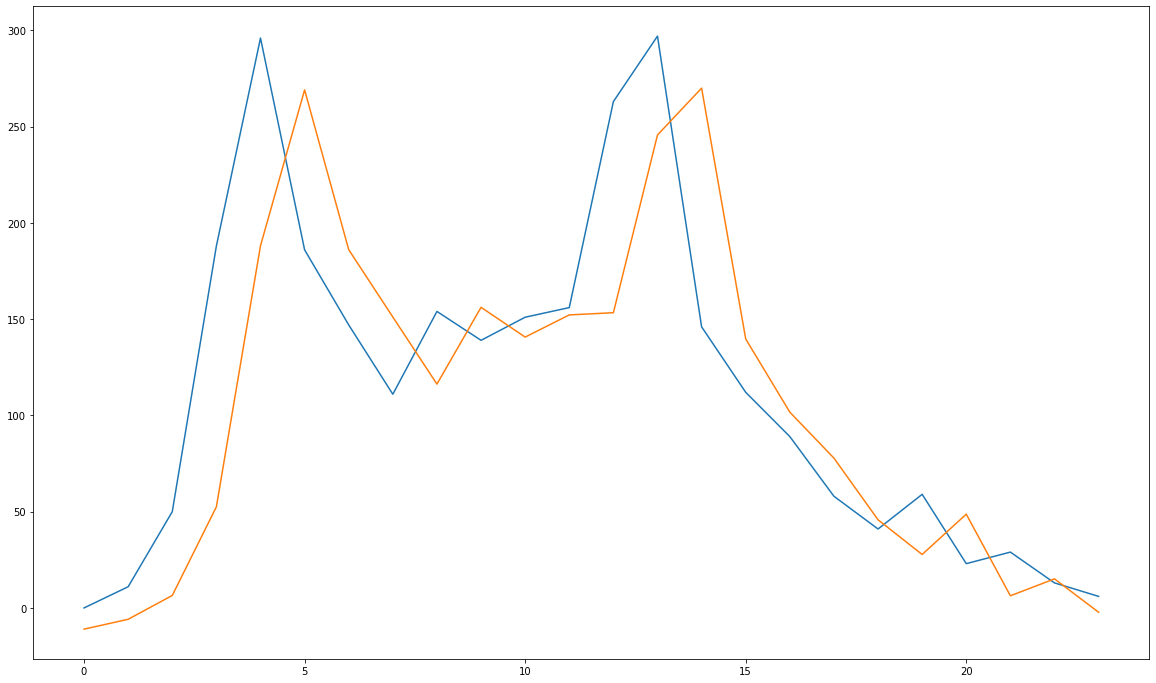

In [151]:
#print(mean_squared_error(LSTM_prediction, LSTM_actual, squared=False))
plt.plot(LSTM_actual[:24])
plt.plot(LSTM_prediction[:24])


#plt.savefig('./figs/predictions/LSTMZoomIn.png')

In [152]:
eval_result(LSTM_prediction, LSTM_actual)

Root Mean Squared Error Very Short term: 11.02171802520752
R2 Very Short term: -29.952866825003298

Root Mean Squared Error Short term: 66.3694076538086
R2 Short term: 0.4702027551644258

Root Mean Squared Error Mid term: 44.695106506347656
R2 Mid term: 0.6587576941862161

Root Mean Squared Error Long term: 36.88335037231445
R2 Long term: 0.6369014486767675



Let's try to optimize this with taking more past timeseries datasets into account.

(8236, 24, 4)
(24, 4)
Epoch 1/50
115/115 - 3s - loss: 0.0171 - root_mean_squared_error: 0.1306 - 3s/epoch - 26ms/step
Epoch 2/50
115/115 - 1s - loss: 0.0117 - root_mean_squared_error: 0.1080 - 1s/epoch - 10ms/step
Epoch 3/50
115/115 - 1s - loss: 0.0098 - root_mean_squared_error: 0.0990 - 1s/epoch - 9ms/step
Epoch 4/50
115/115 - 1s - loss: 0.0080 - root_mean_squared_error: 0.0896 - 991ms/epoch - 9ms/step
Epoch 5/50
115/115 - 1s - loss: 0.0066 - root_mean_squared_error: 0.0813 - 876ms/epoch - 8ms/step
Epoch 6/50
115/115 - 1s - loss: 0.0055 - root_mean_squared_error: 0.0741 - 876ms/epoch - 8ms/step
Epoch 7/50
115/115 - 1s - loss: 0.0047 - root_mean_squared_error: 0.0684 - 873ms/epoch - 8ms/step
Epoch 8/50
115/115 - 1s - loss: 0.0043 - root_mean_squared_error: 0.0656 - 873ms/epoch - 8ms/step
Epoch 9/50
115/115 - 1s - loss: 0.0041 - root_mean_squared_error: 0.0638 - 869ms/epoch - 8ms/step
Epoch 10/50
115/115 - 1s - loss: 0.0039 - root_mean_squared_error: 0.0622 - 871ms/epoch - 8ms/step
Epoc

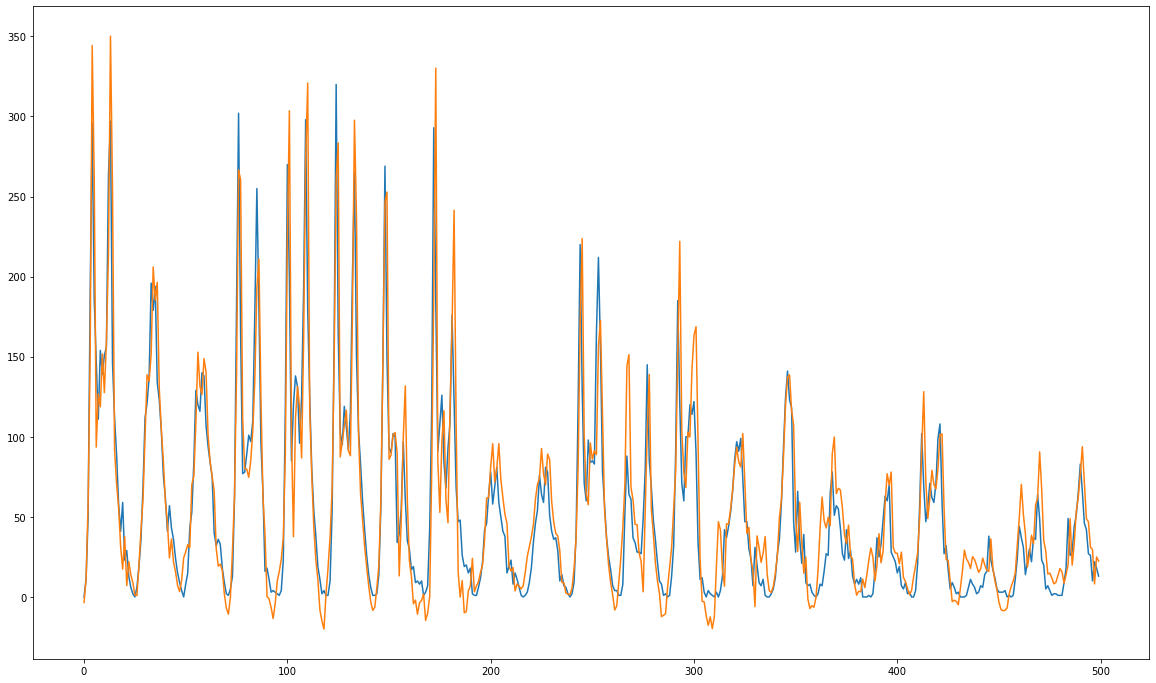

In [153]:
n_hours = 24
n_features = 4

n_obs = n_hours * n_features

reframed_mul = prepare_lstm_dataset(LSTM_data, LSTM_scaler, n_hours)

values_mul = reframed_mul.values
train_mul = values_mul[:-500, :]
test_mul = values_mul[-500:, :]

train_X_mul, train_y_mul = train_mul[:, :n_obs], train_mul[:, -n_features]
test_X_mul, test_y_mul = test_mul[:, :n_obs], test_mul[:, -n_features]

train_X_mul = train_X_mul.reshape((train_X_mul.shape[0], n_hours, n_features))
test_X_mul = test_X_mul.reshape((test_X_mul.shape[0], n_hours, n_features))

print(train_X_mul.shape)
print((train_X_mul.shape[1], train_X_mul.shape[2]))

model_mul = create_LSTM_model((train_X_mul.shape[1], train_X_mul.shape[2]))

fit_LSTM_model(model_mul, train_X_mul, train_y_mul, epochs=50)

# make a prediction
LSTM_normalized_prediction_mul = model_mul.predict(test_X_mul)

test_X_mul = test_X_mul.reshape(len(test_X_mul), n_obs)

# invert scaling for forecast
inv_yhat = np.concatenate((LSTM_normalized_prediction_mul, test_X_mul[:, -n_features+1:]), axis=1)
inv_yhat = LSTM_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y_mul.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_mul[:, -n_features+1:]), axis=1)
inv_y = LSTM_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#print(mean_squared_error(inv_yhat, inv_y, squared=False))
plt.plot(inv_y)
plt.plot(inv_yhat)
#print(mean_absolute_error(inv_yhat, inv_y))

#plt.savefig('./figs/predictions/LSTMOptimized.png')


Root Mean Squared Error Very Short term: 3.4345343112945557
R2 Very Short term: 0.8915034378673264

Root Mean Squared Error Short term: 37.766136169433594
R2 Short term: 0.8613571560414248

Root Mean Squared Error Mid term: 27.58319854736328
R2 Mid term: 0.8781975599860334

Root Mean Squared Error Long term: 28.106094360351562
R2 Long term: 0.8107829210563267



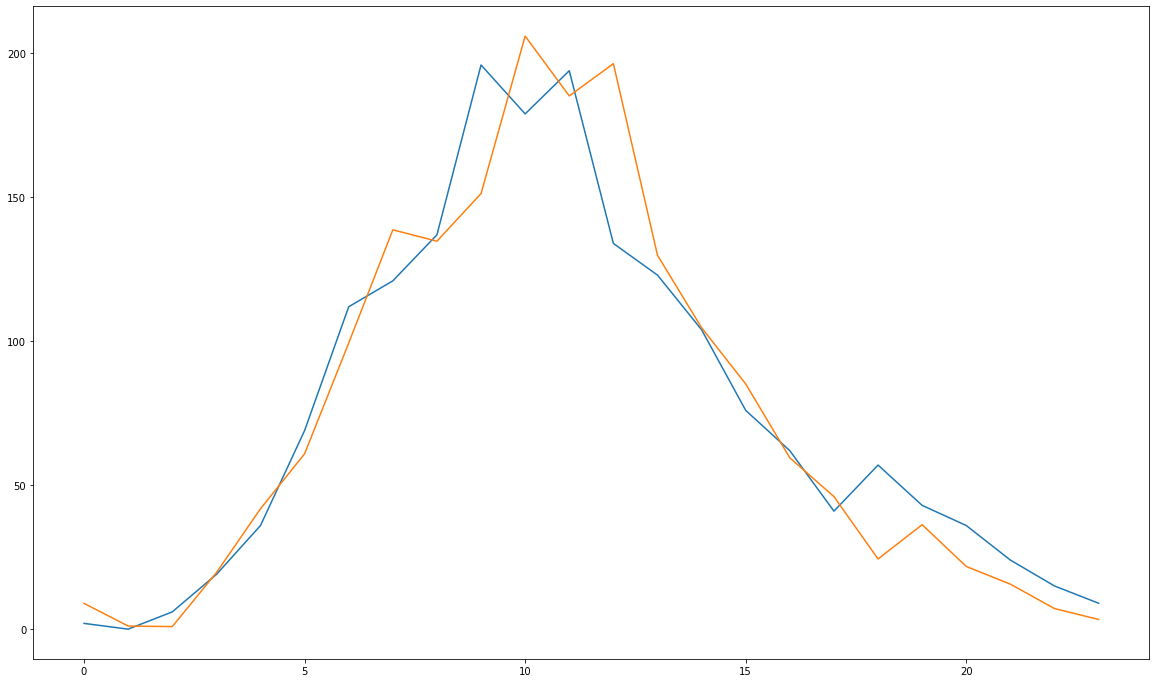

In [154]:
eval_result(inv_yhat, inv_y)

plt.plot(inv_y[24:48])
plt.plot(inv_yhat[24:48])

#plt.savefig('./figs/predictions/LSTMOptimizedZoomIn.png')

Lets try to optimize it even further with trying to add regularization / additional Layers and additional Epochs into account.

Epoch 1/50
114/114 - 4s - loss: 0.0156 - root_mean_squared_error: 0.1247 - 4s/epoch - 33ms/step
Epoch 2/50
114/114 - 3s - loss: 0.0097 - root_mean_squared_error: 0.0982 - 3s/epoch - 26ms/step
Epoch 3/50
114/114 - 3s - loss: 0.0071 - root_mean_squared_error: 0.0838 - 3s/epoch - 23ms/step
Epoch 4/50
114/114 - 2s - loss: 0.0057 - root_mean_squared_error: 0.0753 - 2s/epoch - 21ms/step
Epoch 5/50
114/114 - 2s - loss: 0.0053 - root_mean_squared_error: 0.0723 - 2s/epoch - 21ms/step
Epoch 6/50
114/114 - 2s - loss: 0.0051 - root_mean_squared_error: 0.0710 - 2s/epoch - 20ms/step
Epoch 7/50
114/114 - 2s - loss: 0.0049 - root_mean_squared_error: 0.0695 - 2s/epoch - 20ms/step
Epoch 8/50
114/114 - 2s - loss: 0.0047 - root_mean_squared_error: 0.0683 - 2s/epoch - 21ms/step
Epoch 9/50
114/114 - 2s - loss: 0.0045 - root_mean_squared_error: 0.0672 - 2s/epoch - 20ms/step
Epoch 10/50
114/114 - 2s - loss: 0.0042 - root_mean_squared_error: 0.0646 - 2s/epoch - 20ms/step
Epoch 11/50
114/114 - 2s - loss: 0.0038

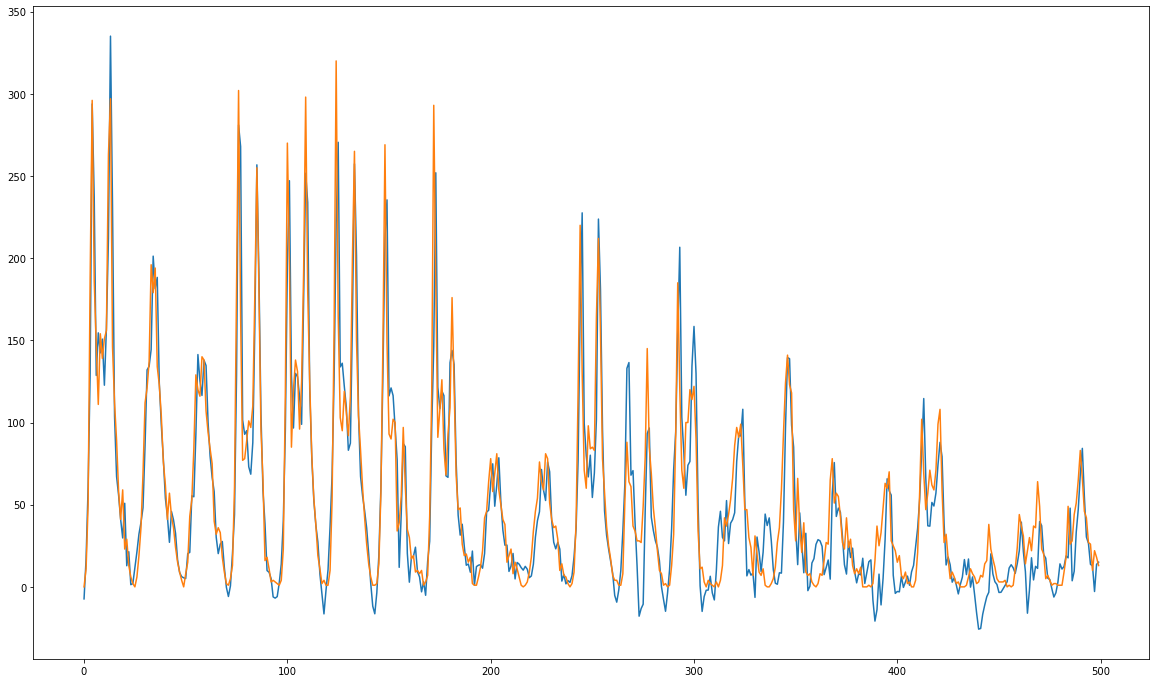

In [155]:

n_hours = 72
n_features = 4

n_obs = n_hours * n_features

reframed_opt = prepare_lstm_dataset(LSTM_data, LSTM_scaler, n_hours)

values_opt = reframed_opt.values
train_opt = values_opt[:-500, :]
test_opt = values_opt[-500:, :]

train_X_opt, train_y_opt = train_opt[:, :n_obs], train_opt[:, -n_features]
test_X_opt, test_y_opt = test_opt[:, :n_obs], test_opt[:, -n_features]

train_X_opt = train_X_opt.reshape((train_X_opt.shape[0], n_hours, n_features))
test_X_opt = test_X_opt.reshape((test_X_opt.shape[0], n_hours, n_features))

#Creating a bigger model
model_opt = tf.keras.models.Sequential()
model_opt.add(LSTM(50, input_shape=(train_X_opt.shape[1], train_X_opt.shape[2]), activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))
model_opt.add(Dense(30))
model_opt.add(Dense(20))
model_opt.add(Dense(1))
model_opt.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#print(train_X_opt.shape)
#print(train_y_opt.shape)

fit_LSTM_model(model_opt, train_X_opt, train_y_opt, epochs=50)

# make a prediction
LSTM_normalized_prediction_opt = model_opt.predict(test_X_opt)

test_X_opt = test_X_opt.reshape(len(test_X_opt), n_obs)

# invert scaling for forecast
inv_yhat = np.concatenate((LSTM_normalized_prediction_opt, test_X_opt[:, -n_features+1:]), axis=1)
inv_yhat = LSTM_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y_opt.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_opt[:, -n_features+1:]), axis=1)
inv_y = LSTM_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#print(mean_squared_error(inv_yhat, inv_y, squared=False))
plt.plot(inv_yhat)
plt.plot(inv_y)
#print(mean_absolute_error(inv_yhat, inv_y))


eval_result(inv_yhat, inv_y)


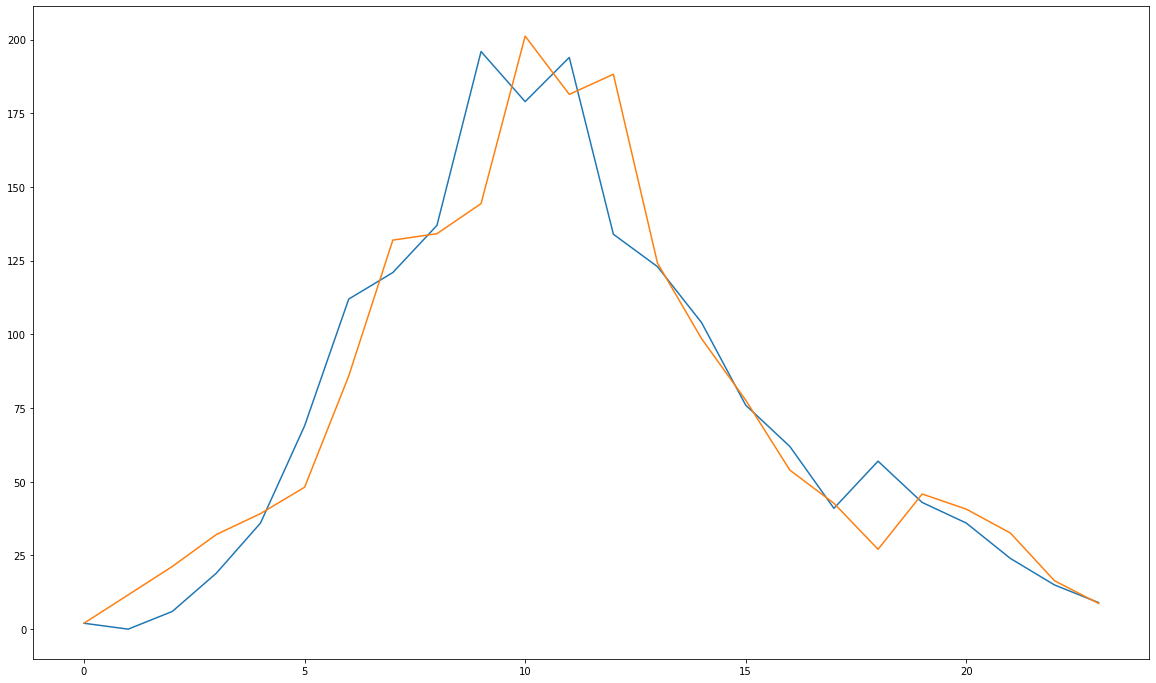

In [156]:

plt.plot(inv_y[24:48])
plt.plot(inv_yhat[24:48])

#plt.savefig('./figs/predictions/LSTMOptimization2.png')



As we can see, the data is not just shifted, but tries to fit the structure of the original data. With a RSME of abaout 25. this is the best model.


### Evaluation

We have compared 3 models:
- Polynomial regression (with multiple features)
- ARIMA model
- LSTM model

Judging by the RMSE values of the last 500 hours of the year, we can see, that the LSTM model is clearly the winner for the long term evaluation.

### Additional: Trying to make use of the complex seasonality

In the dataset, we can see not just one but 3 seasonalities:
- daily: each day, we have low trip-counts at night, high during the day, and two peaks during the times 9:00 and 17:00.
- weekly: similar pattern during the week
- yearly: although a one year dataset is usually not enough to make this statement, there should be a yearly seasonality as well (people riding bikes more often in the summer than in the winter). To be sure about this, we could take other years in account. 

With the ARIMA model, we can take one Seasonality into account (which we did with the daily seasonal activity), but in the next cell, we try to model it manually to different combinations of sine curves, to display the daily, weekly and yearly seasonality, while the yearly being a multiplicative seasonality.

[-5.86449935e+04  4.62783049e+00 -5.58659976e+01  4.62450387e+00
 -5.84536328e+04]
[ 2.19755774e+01  5.28739029e+00  9.82929104e+00  4.79584747e+00
 -3.23414587e-03]
[ 1.07662313e+02  4.10152766e+00  5.18576610e+01  4.41450743e+00
  4.74837685e+01  5.87496157e+00 -9.54362700e-08]
117.91903020762638


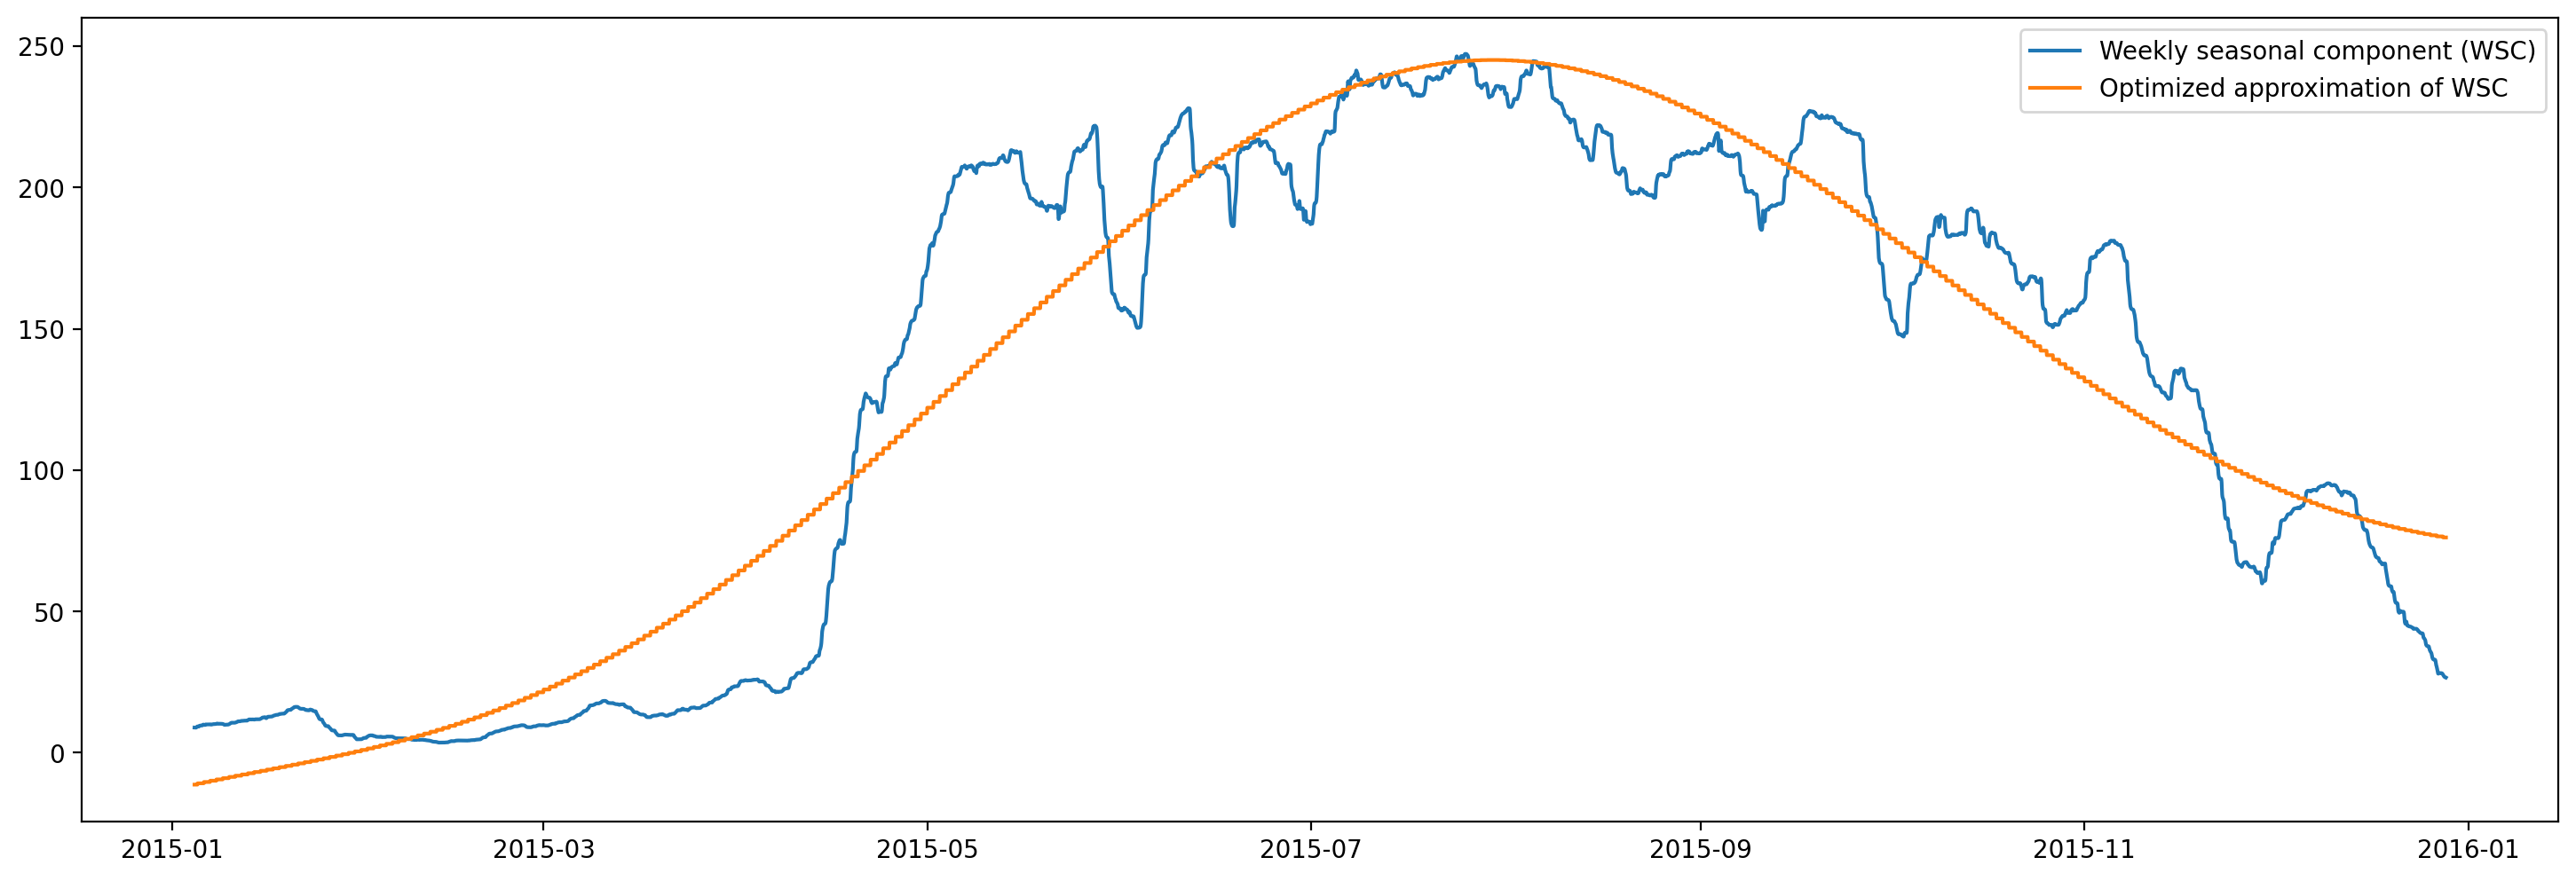

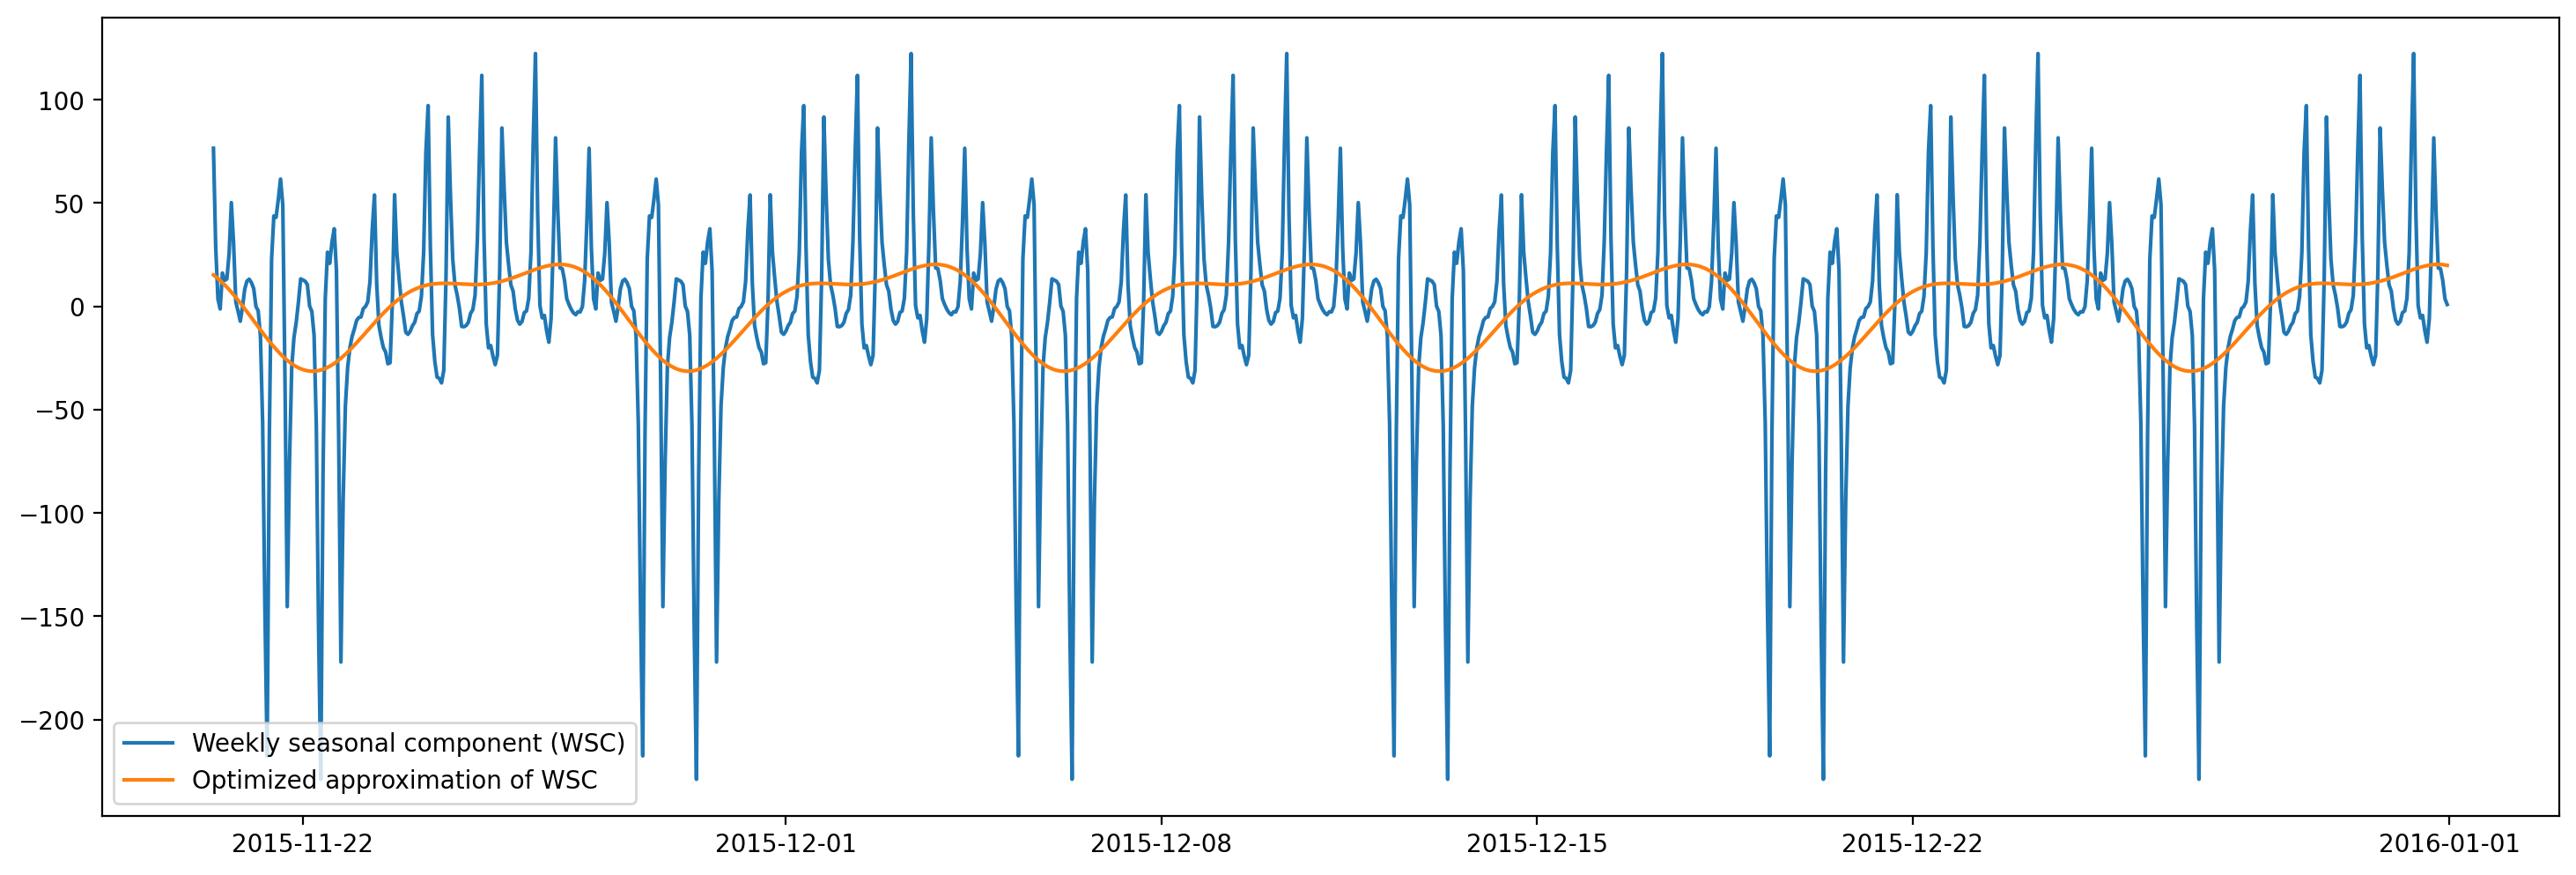

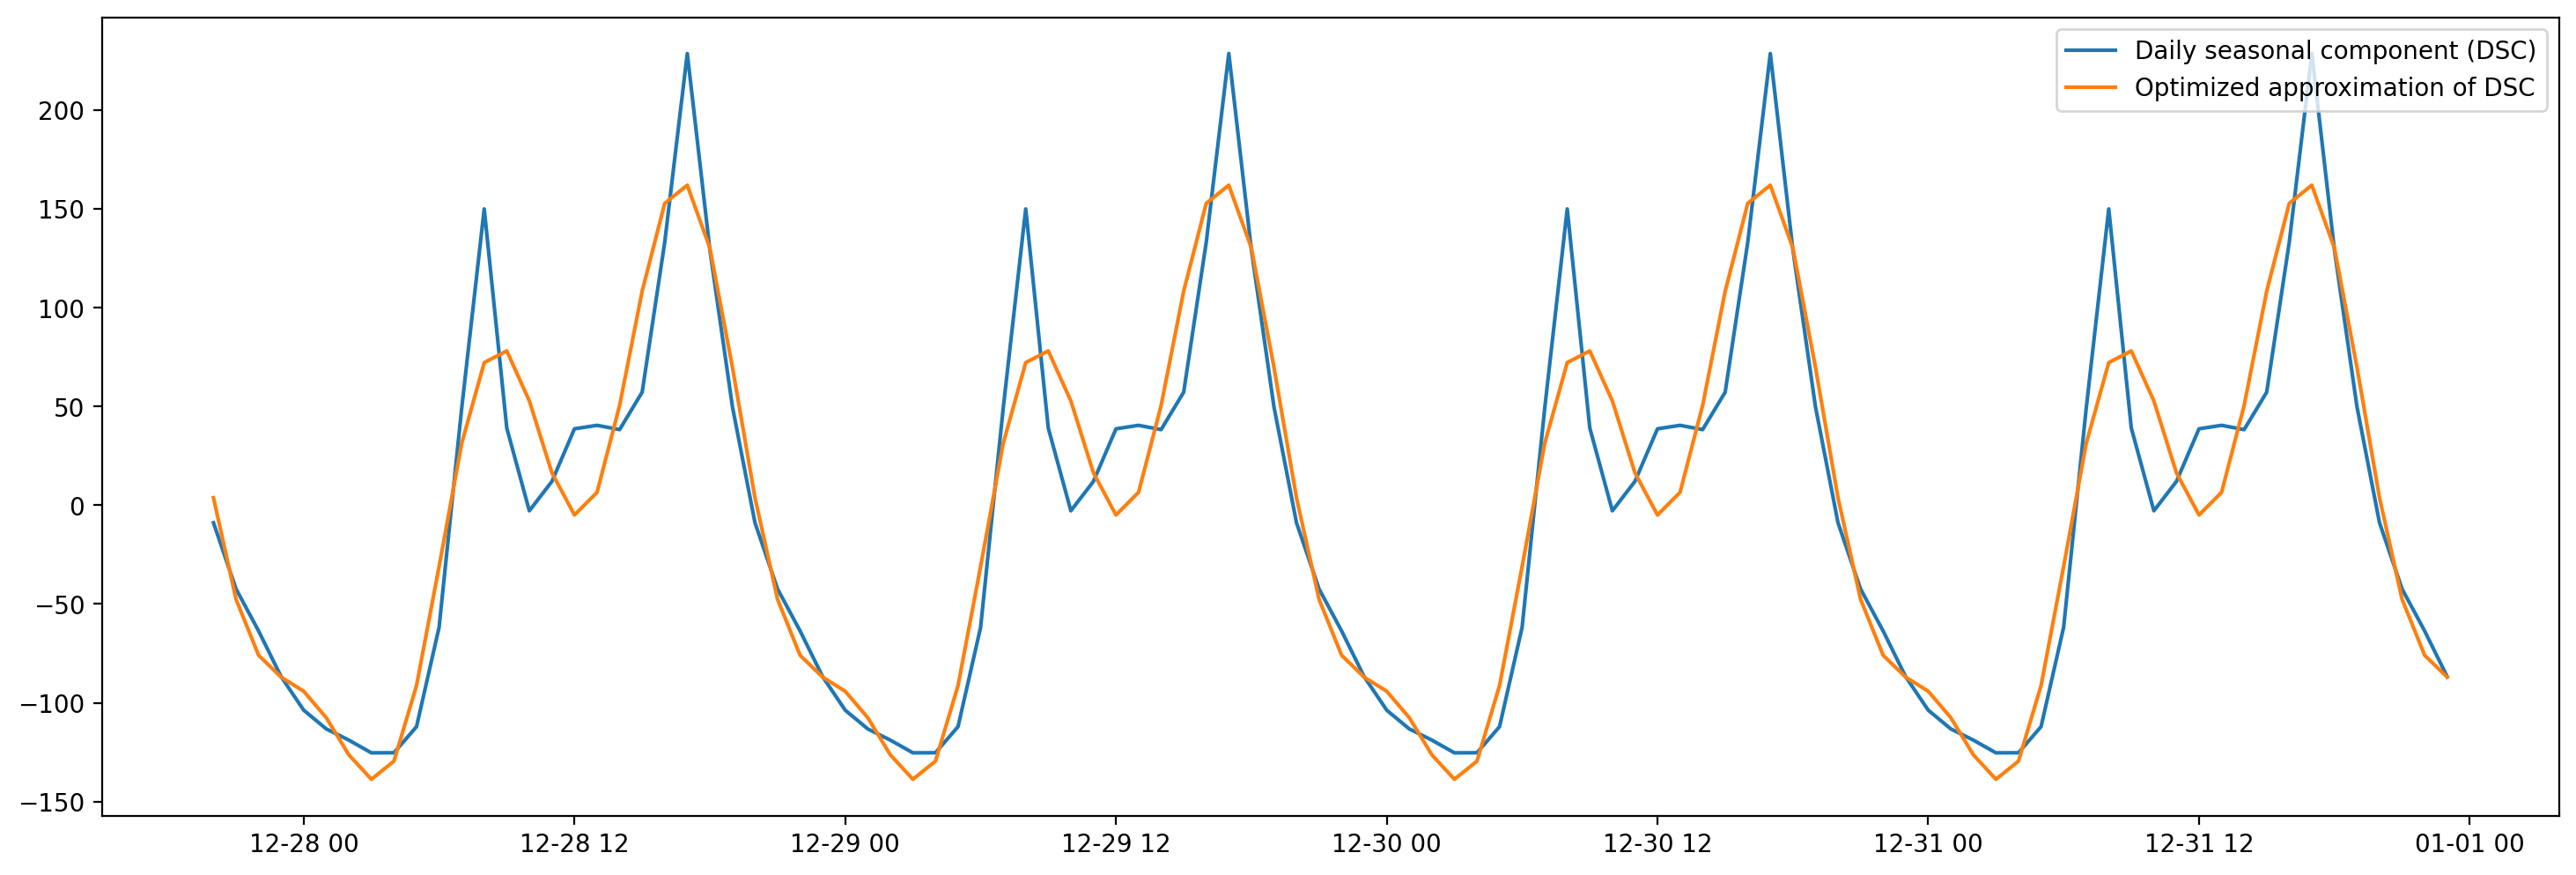

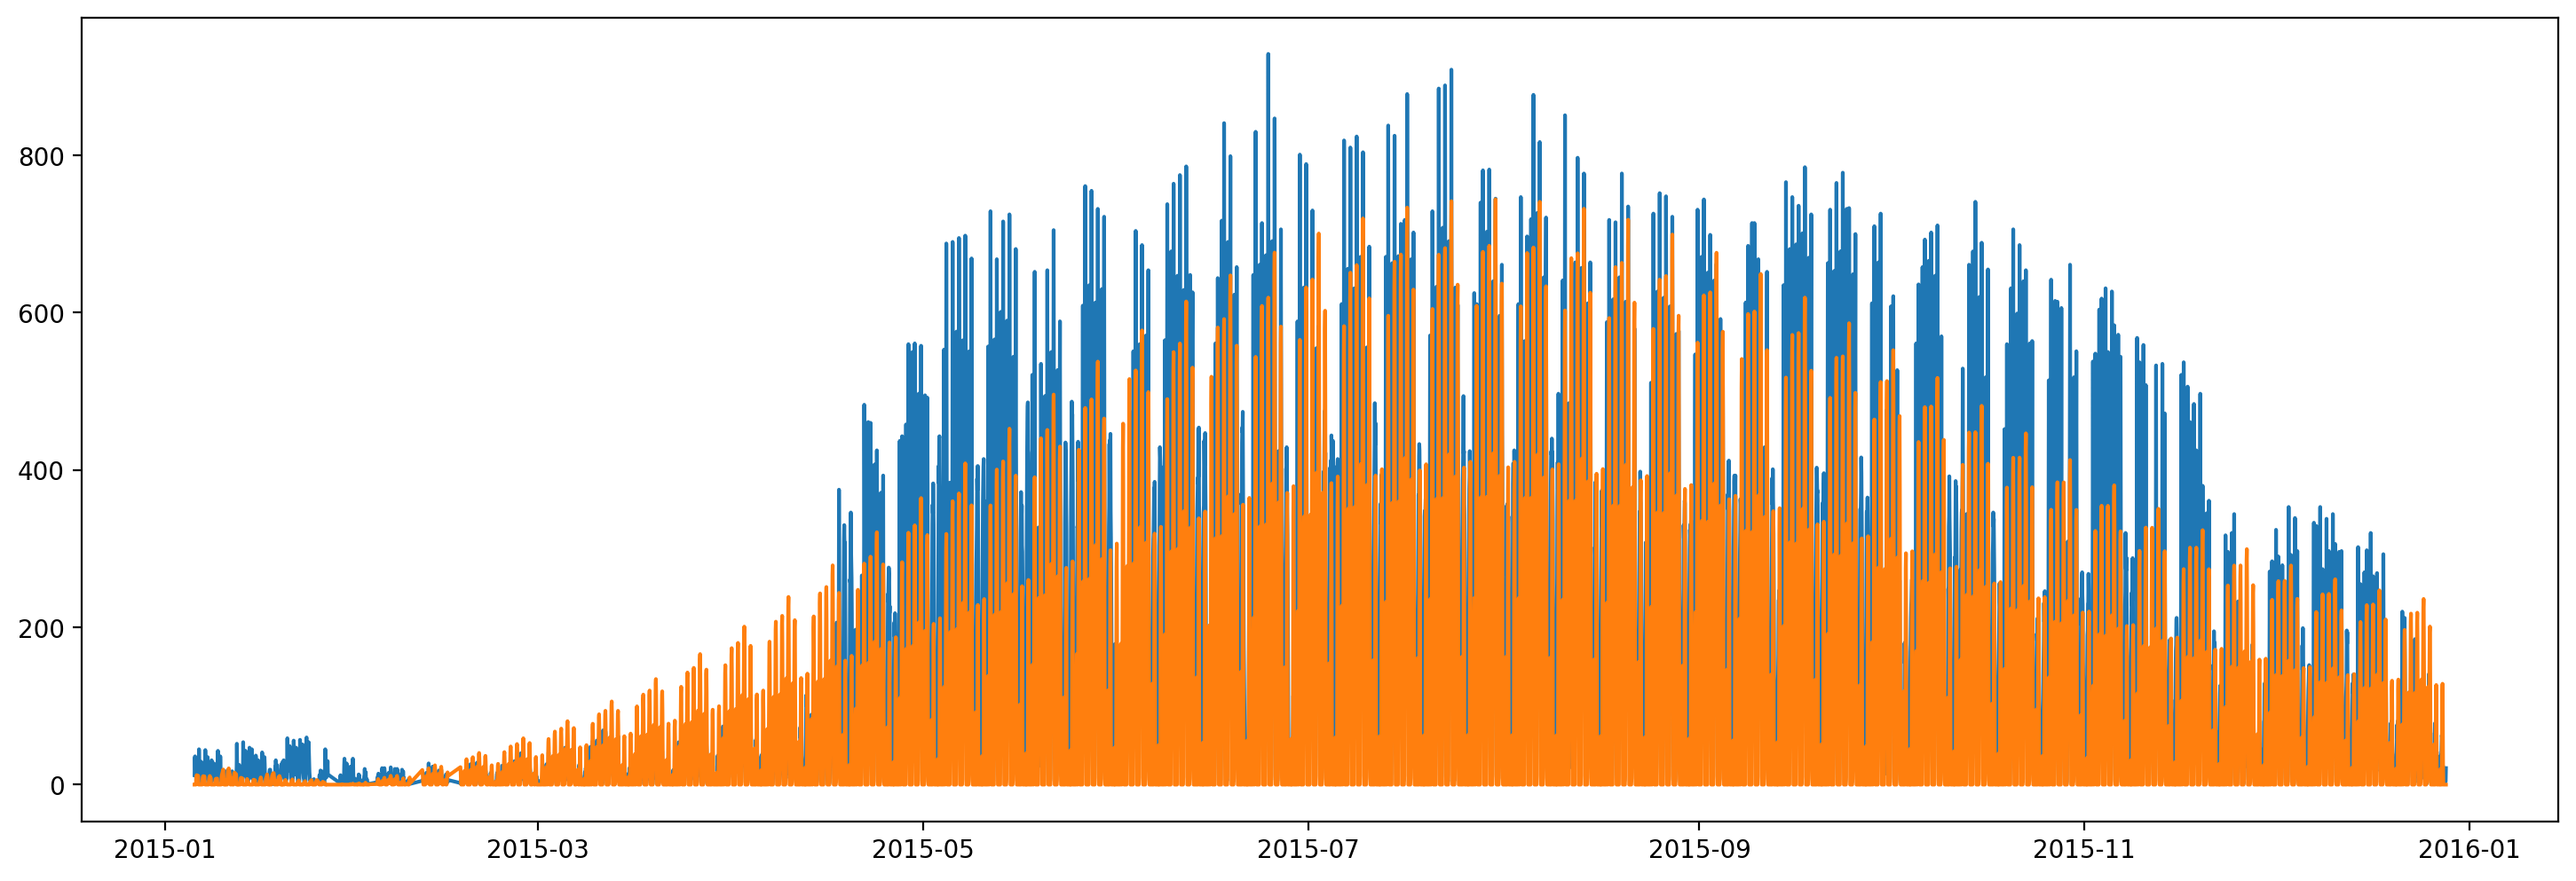

In [157]:
# Own reconstruation of the multiple seasonality (daily, weekly, yearly) by using multiple sin functions
Daily_season = seasonal_decompose(ARIMA_hours, period=24)
Weekly_season = seasonal_decompose(ARIMA_hours - np.array(Daily_season.seasonal).reshape(-1,1), period=168)
yearly_trend = Weekly_season.trend[84:-84]

#hours of the day
idxh = Daily_season.seasonal.index.hour
#hours of the week
idxw = Weekly_season.seasonal.index.dayofweek * 24 + idxh

idxy = yearly_trend.index.dayofyear



def fy(x, A, b, C, d, E):
    return A * np.sin(np.pi/len(idxy) * x + b) + C * np.cos(np.pi/(len(idxy)/64) * x + d) + E

params_y, params_y_covariance = sp.optimize.curve_fit(fy, idxy, yearly_trend, p0=[1400, 4, 600, 4, -200])
print(params_y)

plt.figure(figsize=(18,6),dpi=200);

#plotting arbitrarily selected time window of observed values
plt.plot(Weekly_season.trend, label='Weekly seasonal component (WSC)');

#plotting optimized approximation
plt.plot(yearly_trend.index, fy(idxy, params_y[0],
                                            params_y[1],
                                            params_y[2],
                                            params_y[3],
                                            params_y[4]), label='Optimized approximation of WSC');
plt.legend();

#plt.savefig('./figs/predictions/manuelPredictionYear.png')

def fw(x, A, b, C, d, E):
    return A * np.sin(np.pi/84 * x + b) + C * np.cos(np.pi/42 * x + d) + E

params_w, params_w_covariance = sp.optimize.curve_fit(fw, idxw, Weekly_season.seasonal, p0=[1400, 4, 600, 4, -200])
print(params_w)

plt.figure(figsize=(18,6),dpi=200);

#plotting arbitrarily selected time window of observed values
plt.plot(Weekly_season.seasonal[-1000:], label='Weekly seasonal component (WSC)');

#plotting optimized approximation
plt.plot(Weekly_season.seasonal.index[-1000:], fw(idxw, params_w[0],
                                            params_w[1],
                                            params_w[2],
                                            params_w[3],
                                            params_w[4])[-1000:], label='Optimized approximation of WSC');
plt.legend();

#plt.savefig('./figs/predictions/manuelPredictionWeekly.png')

def fd(x, A, b, C, d, E, f, G):
    return A * np.sin(np.pi/12 * x + b) + C * np.sin(np.pi/6* x + d) + E * np.cos(np.pi/4 * x + f) + G

#optimizing manual approximation using scipy
params_d, params_d_covariance = sp.optimize.curve_fit(fd, idxh, Daily_season.seasonal, p0=[2300, 5, 1000, 5, 1000 , 5, 1])

#printing parameters for daily seasonal component optimized approximation ('fd')
print(params_d)

plt.figure(figsize=(18,6),dpi=200);

#plotting arbitrarily selected time window of observed values
plt.plot(Daily_season.seasonal[-100:], label='Daily seasonal component (DSC)');
#plt.plot(Daily_season.resid[-100:], label='Daily resid component (DSC)');


#plotting optimized approximation
plt.plot(Daily_season.seasonal.index[-100:], fd(idxh, params_d[0],
                                            params_d[1],
                                            params_d[2],
                                            params_d[3],
                                            params_d[4],
                                            params_d[5],
                                            params_d[6])[-100:], label='Optimized approximation of DSC');
plt.legend(loc='upper right');

#plt.savefig('./figs/predictions/manuelPredictionDaily.png')

def create_seasonality_model(time_data):

  hours = time_data.iloc[84:-84]


  idxh_test = hours.index.hour
  idxw_test = hours.index.dayofweek * 24 + idxh_test
  idxy_test = hours.index.dayofyear

  daily = fd(idxh_test, params_d[0],params_d[1],params_d[2],params_d[3],params_d[4],params_d[5],params_d[6])
  weekly = fw(idxw_test, params_w[0],params_w[1],params_w[2],params_w[3],params_w[4])
  yearly = fy(idxy_test, params_y[0],params_y[1],params_y[2],params_y[3],params_y[4])

  def prediction(daily, weekly, yearly):
    forecast_prediction = daily*yearly*0.015 + weekly*yearly*0.03
    return np.array(forecast_prediction).clip(min=0)

  return prediction(daily, weekly, yearly), hours

forecast_prediction, allocated_hours = create_seasonality_model(ARIMA_data)

plt.figure(figsize=(18,6),dpi=200);
plt.plot(allocated_hours.index.values ,allocated_hours.values , label='Forecast');
plt.plot(allocated_hours.index.values ,forecast_prediction, label='Forecast');

#plt.savefig('./figs/predictions/manuelPrediction.png')

print(mean_squared_error(allocated_hours.values,forecast_prediction, squared=False))